In [1]:
import sys
sys.path.append("/opt/sw/hedos/git/")
from blooddvh import CompartmentModel
from blooddvh import BloodDistribution
from blooddvh import tDVH
from blooddvh import bDVH
import numpy as np
#!pip install numpy
#!pip install pandas
#!pip3 install -r /opt/sw/blood-dvh/git/requirements.txt

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#%matplotlib inline
from scipy import *
from scipy import stats
from scipy.interpolate import *
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.offsetbox import AnchoredText

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%matplotlib nbagg


In [42]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs, clim=[0.001,1.0])

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom" )

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-60, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='--', linewidth=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j] > 0:
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                texts.append(text)

    return texts

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "") if x > 0.01 else "<.01"


In [43]:
### Cell for Compartment model

## ------------------------ ##
##       parameters
## ------------------------ ##
top_dir  = "C://Users//franc//Documents//Code_python//hedos//"
#top_dir  = "/home/jv774/db/publications/markov/analysis/"
steps_per_min  = 60 # number of steps per min, e.g.,  step resolutions are 1 sec and 0.1 sec for 60 and 600, respectively
time_per_step  = 60.0/steps_per_min # sec
model    = CompartmentModel(top_dir+"input/ICRP89_compartment_model.xlsx", "male", vol=5.3, cardiac=6.5, resolution=steps_per_min)

# volume corrected version
model_w2 = CompartmentModel(top_dir+"input/ICRP89_compartment_model.xlsx", "male volume_corrected_w2", vol=5.3, cardiac=6.5, resolution=steps_per_min)
print(model_w2.volume)


[0.0115591  0.01205748 0.01402735 0.1948808  0.21526833 0.26806922
 0.41494298 0.41555952 0.44682608 0.48944523 0.50200262 0.51053915
 0.52118567 0.5419109  0.64319633 0.68108292 0.7189755  0.7291745
 0.83248248 0.85179883 0.85200297 0.85242698 0.90624682 0.91250737
 0.9269427  0.93736092 0.97673915 1.        ]


In [44]:
model.markov_weibull
#print(time_per_step)
#print(steps_per_min)

In [67]:
bp0 = BloodDistribution()
# it seems that compartment id is saved as float not int.
bp0.generate_from_markov(model.markov, model.name, model.volume, time_per_step, 1000, 10*steps_per_min);
bp0.save("male.xlsx", "100k_10min_m")
# markov simulation: 1000 -> 100 sec. (Mar31, 2021) but it used to take < 1hr for 1e5 BPs
# time to generate blood distribution 1274.27 (Mar32, 2021)

Time to generate blood distribution: 27.234375 seconds


In [68]:
bp1 = BloodDistribution()
# it seems that compartment id is saved as float not int.
bp1.generate_from_markov_weibull(model_w2.markov_weibull, model_w2.name, model_w2.volume, time_per_step, 1000, 10*steps_per_min);
bp1.save("male.xlsx", "100k_10min_w2_corrected_volume")
# time to generate blood distribution 931.187242 for 10^4 April 13.
#time to generate blood distribution 10349.391656000002 for 10^5 April 13.
#bp1.read_from_excel(?)

Time to generate blood distribution: 9.578125 seconds


In [81]:
print(model_w2.scales)
#print(model.prob)

[  4.71255615   1.62549641   5.66893756   9.26482434  71.75689651
  51.66363354  42.26774462  10.0542359   30.59313292  69.50199846
  68.26064786  69.60557949 104.17207077  40.55768738   4.98009552
   1.86284244   1.85382177  12.47416154  19.82017418   4.97376462
  16.64471795  41.4884       2.63303185  30.62853692  23.54069744
  50.96912154  19.26504338  28.44980885]


In [70]:
### Cell for Drawing transition probabilities
### https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html

## ------------------------ ##
##       parameters
## ------------------------ ##
import matplotlib
top_dir  = "C://Users//franc//Documents//Code_python//hedos//"


# definitions for the axes
left  , width    = 0.2 , 0.7
bottom, height   = 0.1, 0.7
spacing = 0.0

rect_matrix = [left, bottom, width, height]

fig = plt.figure(figsize=(12,12)) 

ax_matrix = plt.axes(rect_matrix)

im, cbar = heatmap(model.prob, model.name, model.name, ax=ax_matrix,
                   cmap="YlGn", cbarlabel="probability")
texts = annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=7)

#print(im.get_size())
lbwh = ax_matrix.get_position().bounds
print(lbwh)
rect_volume = [left, bottom + height-0.025, lbwh[3], 0.1]
ax_volume = plt.axes(rect_volume, sharex=ax_matrix)
ax_volume.tick_params(top=False, bottom=False,labeltop=False, labelbottom=False)

ax_volume.bar(model.name, model.df.volume[0:28]/100, edgecolor='k', facecolor='forestgreen')
ax_volume.spines["top"].set_visible(False)
ax_volume.spines["right"].set_visible(False)
ax_volume.set_ylim([0.01, 0.2])
ax_volume.set_ylabel("volume (a.u)")
#ax_volume.set_yscale("log")

def auto_label(ax, vol):
    # For mean return time
    for i, v in enumerate(vol):
        lbl =  "{:.2f}".format(v).replace("0.", ".").replace("1.00", "") if v > 0.01 else "<.01"
        ax.text(i-0.3, v + 0.012, lbl, color='black', fontsize=7)
        
auto_label(ax_volume, model.df.volume[0:28]/100)

plt.show()
#plt.savefig(top_dir+"results/transition_matrix_male_histogram_with_label.png", dpi=300)


<IPython.core.display.Javascript object>

(0.2, 0.13010000000000002, 0.6397999999999999, 0.6397999999999999)


In [71]:
### Cell for loading Blood-path 

## ------------------------ ##
##       parameters
## ------------------------ ##
#top_dir  = "/home/jv774/db/publications/markov/analysis/"
top_dir  = "C://Users//franc//Documents//Code_python//hedos//"

# Blood path from Weibull (k=2) and volume adjusted
BP_w2 = BloodDistribution()
#BP_w2.read_from_excel(top_dir+"male.xlsx", "100k_10min_w2") #non-adjusted
BP_w2.read_from_excel(top_dir+"male.xlsx", "100k_10min_w2_corrected_volume")
BP_w2.recurrence_time()
BP_w2.transition_time()
BP_w2.temporal_volume()

#vol = bp_w2_v.tv.mean(axis=1)
#for v in vol:
#    print(v*100.0)
#for n, v in zip(BP_w2.names, BP_w2.volumes):
#    print(n, v)
BP_w2.df

100k_10min_w2_corrected_volume.bin


c:\Users\franc\anaconda3\envs\lpt\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\franc\anaconda3\envs\lpt\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\franc\anaconda3\envs\lpt\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\franc\anaconda3\envs\lpt\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\franc\anaconda3\envs\lpt\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,5,5,5,5,5,5,5,5,5,5,...,6,6,6,6,6,6,6,6,6,6
1,6,6,6,6,6,6,6,6,6,6,...,3,3,3,15,15,14,14,14,14,14
2,6,6,6,6,6,6,6,6,6,6,...,19,19,19,19,19,19,19,3,3,3
3,18,18,18,18,18,18,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6
4,4,4,4,4,4,4,4,4,4,4,...,6,6,6,6,6,6,6,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9,9,9,9,9,9,9,9,9,9,...,22,17,17,17,17,17,17,17,17,17
996,14,14,16,16,16,22,22,22,22,22,...,6,6,6,6,6,6,6,6,6,6
997,14,14,14,14,14,16,16,16,22,22,...,14,16,16,22,22,22,22,22,22,17
998,11,11,11,11,11,11,11,3,3,3,...,15,15,15,15,14,14,14,14,14,16


In [77]:
# Blood path from pure Markov

BP_m = BloodDistribution()
BP_m.read_from_excel(top_dir+"male.xlsx", "100k_10min_m")
BP_m.df
#BP_m.recurrence_time()
#BP_m.transition_time()
#BP_m.temporal_volume()


100k_10min_m.bin


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,16,16,22,22,22,19,19,19,19,19,...,22,6,6,6,6,6,6,6,6,6
1,15,15,15,14,14,14,14,14,14,14,...,23,23,23,23,23,23,23,23,23,23
2,13,13,13,13,13,13,13,13,13,13,...,3,3,3,15,15,14,14,14,14,16
3,5,5,5,5,5,5,5,5,5,5,...,26,26,26,26,26,26,26,26,26,26
4,3,15,15,15,15,14,14,14,16,16,...,3,3,3,3,3,15,15,15,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,22,5,5,5,5,5,5,5,5,...,9,9,9,9,9,9,9,9,9,9
996,11,11,11,11,11,11,11,11,11,11,...,18,18,18,18,18,18,18,18,18,18
997,3,3,3,3,3,3,3,3,3,15,...,24,24,24,24,24,24,24,24,24,24
998,6,6,6,6,6,6,6,6,6,6,...,9,9,9,9,9,9,9,9,9,9


In [73]:
# Blood path from Weibull (k=1)
#BP_w1 = BloodDistribution()
#BP_w1.read_from_excel(top_dir+"male.xlsx", "100k_10min_w1")
#BP_w1.recurrence_time()
#BP_w1.transition_time()
#BP_w1.temporal_volume()

In [74]:
colors = [plt.cm.tab20(i%20) for i in range(28)]
colors[20] = plt.cm.Set3(1)    
colors[21] = plt.cm.Set3(2)    
colors[22] = plt.cm.Set3(3)    
colors[23] = plt.cm.Set3(4)    
colors[24] = plt.cm.Set3(5)    
colors[25] = plt.cm.Set3(6)    
colors[26] = plt.cm.Set3(7)    
colors[27] = plt.cm.Set3(8)    
comp_cmap=matplotlib.colors.ListedColormap(colors)


In [84]:

"!!! j'ai fait une modifition : commentée la ligne vol_avg pour le modèle BP_m car ca ne fonctionne pas"

#print(model.df.volume[0:model.size]
# ---- temporal volume for Markov, Wk=1, Wk=2, or Wk=5
vol_avg = np.zeros([model.size, 3])
vol_std = np.zeros([model.size, 3])
vol_rel = np.zeros([model.size, 3])

for i in range(model.size):
    #vol_avg[i,0], vol_std[i,0], vol_rel[i,0] = 100.0*BP_m.tv[i, 0:].mean() , 100.0*BP_m.tv[i, 0:].std() , 100.0*BP_m.tv[i, 0:].mean()/model.df.volume[i]
    vol_avg[i,0], vol_std[i,0], vol_rel[i,0] = 100.0*BP_w2.tv[i, 0:].mean() , 100.0*BP_w2.tv[i, 0:].std() , 100.0*BP_w2.tv[i, 0:].mean()/model.df.volume[i]
    vol_avg[i,1], vol_std[i,1], vol_rel[i,1] = 100.0*BP_w2.tv[i, 0:].mean(), 100.0*BP_w2.tv[i, 0:].std(), 100.0*BP_w2.tv[i, 0:].mean()/model.df.volume[i]
    vol_avg[i,2], vol_std[i,2], vol_rel[i,2] = 100.0*BP_w2.tv[i, 0:].mean(),100.0*BP_w2.tv[i, 0:].std(), 100.0*BP_w2.tv[i, 0:].mean()/model.df.volume[i]
    print(r"{:d} {:.2f} M: {:.2f} {:.4f} {:.2f}, W1: {:.2f} {:.4f} {:.2f}, W2: {:.2f} {:.4f} {:.2f}"
       .format(i, model.df.volume[i],
               100.0*vol_avg[i, 0], 100.0*vol_std[i, 0].std(), 100.0*vol_rel[i,0],
               100.0*vol_avg[i, 1], 100.0*vol_std[i, 1].std(), 100.0*vol_rel[i,1],
               100.0*vol_avg[i, 2], 100.0*vol_std[i, 2].std(), 100.0*vol_rel[i,2]
              ) )

#print(vol_std)
#print(model.name)
# volume: brain & liver in table for M, W1, W2

# ------ Draw grid images
fig, ax = plt.subplots(figsize=(9,5)) 
fig.subplots_adjust(left=0.2, bottom=0.2)

# forestgreen
ax.bar(model.name, model.df.volume[0:model.size], edgecolor='k', linewidth=0.5, linestyle='--', alpha=0.5, facecolor='forestgreen', label="ICRP")

x_pos = np.arange(0.0, 28.0, 1)

ax.errorbar( x_pos - 0.2, vol_avg[0:,0], yerr=vol_std[0:,0],  markersize=5, fmt='s',  capthick=12, label="Constant") #mfc='none', mec='k', color='k',
#ax.errorbar( x_pos       , vol_avg[0:,1], yerr=vol_std[0:,1], alpha=0.9, markersize=5, fmt='yo', capthick=12, label=r"Weibull, $\kappa=2$")
ax.errorbar( x_pos + 0.2, vol_avg[0:,2], yerr=vol_std[0:,2], markersize=5, fmt='^',  capthick=12, label="Weibull") #mfc='none', mec='k', color='k',
ax.legend(loc='upper right')

#ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.set_ylim([-0.1, 19])
ax.set_ylabel("volume (%)")
plt.setp(ax.get_xticklabels(), rotation=-60, ha="left",rotation_mode="anchor")

plt.show()

#fig.savefig(top_dir+"results/blood_path_100K_10min_m_w2_volume_corrected.png", dpi=300)


0 1.20 M: 122.88 0.0000 102.40, W1: 122.88 0.0000 102.40, W2: 122.88 0.0000 102.40
1 0.06 M: 6.83 0.0000 113.89, W1: 6.83 0.0000 113.89, W2: 6.83 0.0000 113.89
2 0.20 M: 20.53 0.0000 102.67, W1: 20.53 0.0000 102.67, W2: 20.53 0.0000 102.67
3 18.00 M: 1805.13 0.0000 100.29, W1: 1805.13 0.0000 100.29, W2: 1805.13 0.0000 100.29
4 1.92 M: 193.28 0.0000 100.67, W1: 193.28 0.0000 100.67, W2: 193.28 0.0000 100.67
5 5.00 M: 491.00 0.0000 98.20, W1: 491.00 0.0000 98.20, W2: 491.00 0.0000 98.20
6 14.00 M: 1411.97 0.0000 100.85, W1: 1411.97 0.0000 100.85, W2: 1411.97 0.0000 100.85
7 0.06 M: 5.53 0.0000 92.22, W1: 5.53 0.0000 92.22, W2: 5.53 0.0000 92.22
8 3.00 M: 295.70 0.0000 98.57, W1: 295.70 0.0000 98.57, W2: 295.70 0.0000 98.57
9 4.00 M: 385.13 0.0000 96.28, W1: 385.13 0.0000 96.28, W2: 385.13 0.0000 96.28
10 1.20 M: 111.77 0.0000 93.14, W1: 111.77 0.0000 93.14, W2: 111.77 0.0000 93.14
11 0.80 M: 103.08 0.0000 128.85, W1: 103.08 0.0000 128.85, W2: 103.08 0.0000 128.85
12 1.00 M: 105.50 0.0000

<IPython.core.display.Javascript object>

In [86]:
"!!! j'ai fait une modifition : commentée les 2 ligne BP_m décallée"

############################################
#### Transition time distribution (A) : Brain-TT (B) : Liver-TT
#### Returning time distribution  (C) : Brain-RT (D) : Liver-RT
############################################

total_nb_particles = 100_000

# histograms side by side for Brain & Liver
fig = plt.figure(figsize=(10,5)) 
fig.subplots_adjust(wspace=0.05)
img_grid = (1,2)

# options for markov and 
kwargs_m = dict(edgecolor='k', linewidth=1.2, linestyle='-' , bins=range(0,90,1), density=True, histtype='step')
kwargs_w = dict(edgecolor='gray', linewidth=1.2, linestyle='--', bins=range(0,90,1), density=True, histtype='step')
kwargs_mb = dict(edgecolor='k', linewidth=1.2, linestyle='-' , bins=range(0, 600,10), density=True, histtype='step')
kwargs_wb = dict(edgecolor='gray', linewidth=1.2, linestyle='--', bins=range(0,600,10), density=True, histtype='step')


# Brain
ax1a = plt.subplot2grid(img_grid, (0, 0))
#                                  ax1a.hist(BP_m.ttd['brain'], **kwargs_m, label="Constant")
ax1a.hist(BP_w2.ttd['brain'], **kwargs_w, label=r"Weibull")

ax1a.legend(loc='center right')
ax1a.set_xlabel("Time (sec)")
ax1a.set_xlim([-2, 30])
ax1a.set_ylim([0, 0.21])
ax1a.set_ylabel("Frequency")
#ax1a.set_title("(A) Brain transition time")

#ax1b = plt.subplot2grid(img_grid, (0, 1))
#ax1b.hist(BP_m.rtd['brain'], **kwargs_mb, label="Constant")
#ax1b.hist(BP_w2.rtd['brain'], **kwargs_wb, label="Weibull")
##ax1b.legend()
#ax1b.set_xlabel("Time (sec)")
##ax1b.set_xlim([-2, 30])
#ax1b.set_ylabel("Frequency")
##ax1b.set_title("(B) Brain return time")


# Liver
ax2a = plt.subplot2grid(img_grid, (0, 1))

#                          ax2a.hist(BP_m.ttd['liver'], **kwargs_m, label="Constant")
ax2a.hist(BP_w2.ttd['liver'], **kwargs_w, label=r"Weibull")
#ax2a.legend()
ax2a.set_ylim([0, 0.06])
ax2a.set_xlabel("Time (sec)")
ax2a.set_ylabel("Frequency")
#ax2a.set_title("(C) Liver transition time")

#ax2b = plt.subplot2grid(img_grid, (1, 1))
#ax2b.hist(BP_m.rtd['liver'], **kwargs_mb, label="Constant")
#ax2b.hist(BP_w2.rtd['liver'], **kwargs_wb, label=r"Weibull")
##ax2b.legend()
#ax2b.set_xlabel("Time (sec)")
#ax2b.set_ylabel("Frequency")
#ax2b.set_title("(B) Liver return time")

ax1a.set_title("(A) Brain transition time distribution")
#ax1b.set_title("(B) Brain returning time distribution")
ax2a.set_title("(B) Liver transition time distribution")
#ax2.set_title("(D) Liver returning time distribution")

#txt_1a = AnchoredText("(A) Brain transition-time distribution", loc=9, frameon=False)
#txt_1b = AnchoredText("(B) Brain returning-time distribution", loc=9, frameon=False)
#txt_2a = AnchoredText("(C) Liver transition-time distribution", loc=9, frameon=False)
#txt_2b = AnchoredText("(D) Liver returning-time distribution", loc=9, frameon=False)
#ax1a.add_artist(txt_1a)
#ax1b.add_artist(txt_1b)
#ax2a.add_artist(txt_2a)
#ax2b.add_artist(txt_2b)

#fig.savefig(top_dir+"results/ttd_brain_liver_m_w2_adjusted.png", dpi=300)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '(B) Liver transition time distribution')

In [89]:
### TT or RT metrics
"""
print(len(BP_m.ttd['brain']))
brain_m_ttd = np.array( BP_m.ttd['brain'])
print(100.0*brain_m_ttd[brain_m_ttd > 12].size/len(BP_m.ttd['brain']))
"""
brain_w_ttd = np.array( BP_w2.ttd['brain'])
print(len(BP_w2.ttd['brain']))
print(100.0*brain_w_ttd[brain_w_ttd > 12].size/len(BP_w2.ttd['brain']))

0 in BP_m.df.values[0:,0]
bp0 = 0 
for i in range(100_000):
    if 0 in BP_m.df.values[i,0:] :
        bp0 +=1
print(bp0)

1158
1.7271157167530224
765


In [40]:
### Mean TT & RT with two sided bar chart 

def draw_mrt_mtt(ax, names, v_left, v_right):
    ax.barh(names, -1.0*v_left, edgecolor='k', linewidth=0.5, linestyle='-',facecolor='orange', alpha=.9)
    ax.barh(names, v_right, edgecolor='k', linewidth=0.5, linestyle='-',facecolor='crimson', alpha=.8)
    ax.set_yticks(np.arange(28+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle=':', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xticks([-100,-50,0,50,100,150,200])
    ax.set_xticklabels(["100", "50","0", "50","100","150","200"])
    ax.set_ylim([-0.5,27.5])
    ax.set_xlim([-110.0,220.0])
    ax.text(0, -2.5, r"$\mathbf{\longrightarrow}$ MRT (sec)", color="black")
    ax.text(-75, -2.5, r"MTT (sec) $\mathbf{\longleftarrow}$ ", color="black")

def auto_label(ax, v_left, v_right):
    # For mean return time
    for i, v in enumerate(v_right):
        lbl =  "{:.1f}".format(v)
        if v > 30:
            ax.text(5, i -.2 , lbl, color='white', fontweight='bold', fontsize=8)
        else:
            ax.text(v + 3, i -.2 , lbl, color='black', fontweight='bold', fontsize=8)

    # For mean transition time        
    for i, v in enumerate(v_left):
        lbl =  "{:.1f}".format(v)
        if v > 30:
            ax.text(-30, i -.2, lbl, color='white', fontweight='bold', fontsize=8)
        else:
            ax.text(-v-30, i -.2, lbl, color='black', fontweight='bold', fontsize=8)


fig, ax = plt.subplots(figsize=(10,6)) 
fig.tight_layout(pad=.1)
img_grid = (1,2)


ax  = plt.subplot2grid(img_grid, (0, 0))
mtt = np.array(list(BP_m.mtt.values()))[0:,0]
mrt = np.array(list(BP_m.mrt.values()))[0:,0]
draw_mrt_mtt(ax, list(BP_m.mtt.keys()), mtt, mrt)
auto_label(ax, mtt, mrt)
ax.set_title("(C) Constant")

ax1 = plt.subplot2grid(img_grid, (0, 1))
mtt = np.array(list(BP_w2.mtt.values()))[0:,0]
mrt = np.array(list(BP_w2.mrt.values()))[0:,0]
draw_mrt_mtt(ax1, list(BP_w2.mtt.keys()), mtt, mrt)
auto_label(ax1, mtt, mrt)
ax1.set_yticklabels([])
ax1.set_title(r"(D) Weibull")

fig.subplots_adjust(left=0.05, bottom=0.05, wspace=0.0)
plt.show()

#fig.savefig(top_dir+"results/mtt_vs_mrt_all_m_w2_adjusted_c_d.png", dpi=300)


<IPython.core.display.Javascript object>

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [91]:
### Cell for loading TPS DVH 

## ------------------------ ##
##       parameters
## ------------------------ ##
top_dir  = "C://Users//franc//Documents//Code_python//hedos//"
#top_dir  = "/home/jv774/db/publications/markov/analysis/"

# prescription dose (Gy), 
# number of fraction (N)

delivery = {"brain" : [59.40, 33], "liver": [52.5, 15]}

# Brain-DVH 
BrainDVH = [ np.loadtxt(top_dir+"results/DVHs/Brain/"+e, skiprows=1, delimiter=',') for e in ['BrainComposite.csv','BrainField1.csv', 'BrainField2.csv', 'BrainField3.csv','BrainField4.csv', 'BrainField5.csv', 'BrainField6.csv'] ]
for l in BrainDVH:
    l[0:,0] /= delivery["brain"][1]

## Liver-DVH
LiverDVH = [np.loadtxt(top_dir+"results/DVHs/Liver/"+e, skiprows=1, delimiter=',') for e in  ['LiverComposite.csv','LiverField1.csv', 'LiverField2.csv']]
for l in LiverDVH:
    l[0:,0] /= delivery["liver"][1]
    

FileNotFoundError: C://Users//franc//Documents//Code_python//hedos//results/DVHs/Brain/BrainComposite.csv not found.

In [14]:
LiverDVH[0]

array([[0.00000000e+00, 1.00000000e+02],
       [6.66666667e-03, 3.96453600e+01],
       [1.33333333e-02, 3.84434500e+01],
       ...,
       [3.63333333e+00, 3.90000000e-02],
       [3.64000000e+00, 5.31000000e-03],
       [3.64666667e+00, 0.00000000e+00]])

In [92]:
# Beam delivery time

import pandas as pd

BDVH_dT = pd.DataFrame(columns=['site' , 'T', 'P',
                                 'V0'   ,'V0_Dmean'   , 'V0_Dstd',
                                 'V0.05','V0.05_Dmean', 'V0.05_Dstd',
                                 'D2%'  ,'D2%_Dmean'  , 'D2%_Dstd',
                                 'D3%'  ,'D3%_Dmean'  , 'D3%_Dstd'])

delivery_time  = np.array([1, 10, 60, 120])
start_time     = 10

Brain_tDVH = [tDVH(), tDVH(),tDVH(),tDVH(), tDVH()] 
Liver_tDVH = [tDVH(), tDVH(),tDVH(),tDVH(), tDVH()] 
for j, t in enumerate(delivery_time):
    print(j,t)
    Brain_tDVH[j].add_array(t, BrainDVH[0]) # composite DVH
    Liver_tDVH[j].add_array(t, LiverDVH[0]) # composite DVH


Brain = [[ bDVH(BP_m.df, BP_m.dt)  , bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt) ], # 1-row: markov
         [ bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt) ]] # 2-row: Weibull

Liver = [[ bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt) ], # 1-row: markov
         [ bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt) ]] # 2-row: Weibull


#Brain[0][0] ~ Brain[0][4] : Markov path and delivery 1 sec to 120 sec
#Brain[1][0] ~ Brain[1][4] : Weibull path and delivery 1 sec to 120 sec

# Dose-rate
# composite field but different delivery time
for i in range(2):
    # i = 0 : markov
    # i = 1 : Weibull, k=2
    for j, t in enumerate(delivery_time):
        print(j,t)
        Brain[i][j].add_dose(Brain_tDVH[j], 0, start_time) # 0 : Brain
        
        d0 = Brain[i][j].volume_gt_dose(0.0)
        d1 = Brain[i][j].volume_gt_dose(0.05)
        v0 = Brain[i][j].dose_at_top_volume(2.0)
        v1 = Brain[i][j].dose_at_top_volume(3.0)


        BDVH_dT = BDVH_dT.append({ 'site': 'brain', 'T'  : t,  'P' : i, 
                                     'V0'    : d0[0], 'V0_Dmean'    : d0[1], 'V0_Dstd'   : d0[2], 
                                     'V0.05' : d1[0], 'V0.05_Dmean' : d1[1], 'V0.05_Dstd': d1[2],
                                     'D2%'   : v0[0], 'D2%_Dmean'   : v0[1], 'D2%_Dstd'  : v0[2],
                                     'D3%'   : v1[0], 'D3%_Dmean'   : v1[1], 'D3%_Dstd'  : v1[2]},ignore_index=True)

# For Liver        
for i in range(2):
    # i = 0 : markov
    # i = 1 : Weibull, k=2
    for j, t in enumerate(delivery_time):
        print(j,t)
        Liver[i][j].add_dose(Liver_tDVH[j], 18, start_time) # 18: Liver
        
        d0 = Liver[i][j].volume_gt_dose(0.0)
        d1 = Liver[i][j].volume_gt_dose(0.05)
        v0 = Liver[i][j].dose_at_top_volume(2.0)
        v1 = Liver[i][j].dose_at_top_volume(3.0)


        BDVH_dT = BDVH_dT.append({ 'site': 'liver', 'T'  : t,  'P' : i, 
                                     'V0'    : d0[0], 'V0_Dmean'    : d0[1], 'V0_Dstd'   : d0[2], 
                                     'V0.05' : d1[0], 'V0.05_Dmean' : d1[1], 'V0.05_Dstd': d1[2],
                                     'D2%'   : v0[0], 'D2%_Dmean'   : v0[1], 'D2%_Dstd'  : v0[2],
                                     'D3%'   : v1[0], 'D3%_Dmean'   : v1[1], 'D3%_Dstd'  : v1[2]},ignore_index=True)

        
#BDVH_dT.to_excel("paper_dose_rate_feb24.xlsx", sheet_name="delivery_time", index=False)


0 1


NameError: name 'BrainDVH' is not defined

<IPython.core.display.Javascript object>


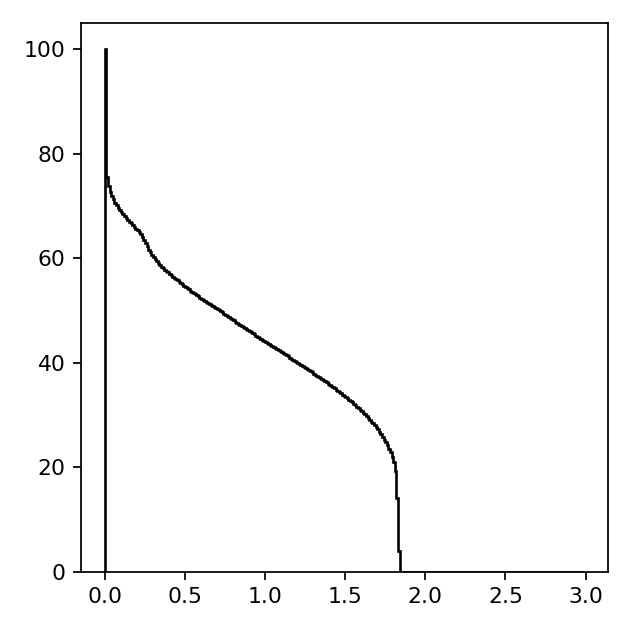

     site    T  P   V0  V0_Dmean  V0_Dstd  V0.05  V0.05_Dmean  V0.05_Dstd  \
8   liver    1  0  0.0       NaN      NaN    0.0          NaN         NaN   
9   liver   10  0  0.0       NaN      NaN    0.0          NaN         NaN   
10  liver   60  0  0.0       NaN      NaN    0.0          NaN         NaN   
11  liver  120  0  0.0       NaN      NaN    0.0          NaN         NaN   
12  liver    1  1  0.0       NaN      NaN    0.0          NaN         NaN   
13  liver   10  1  0.0       NaN      NaN    0.0          NaN         NaN   
14  liver   60  1  0.0       NaN      NaN    0.0          NaN         NaN   
15  liver  120  1  0.0       NaN      NaN    0.0          NaN         NaN   

    D2%  D2%_Dmean  D2%_Dstd  D3%  D3%_Dmean  D3%_Dstd  
8   0.0        0.0       0.0  0.0        0.0       0.0  
9   0.0        0.0       0.0  0.0        0.0       0.0  
10  0.0        0.0       0.0  0.0        0.0       0.0  
11  0.0        0.0       0.0  0.0        0.0       0.0  
12  0.0        0.0   

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
# histograms side by side for Brain & Liver
#print(BDVH_dT)
#BDVH_dT.to_excel("paper_dose_rate.xlsx", sheet_name="source", index=False)
fig = plt.figure(figsize=(4,4)) 
img_grid = (1,1)
ax1 = plt.subplot2grid(img_grid, (0, 0))

#my_bins = np.arange(0.0, 0.8, 0.05)
#my_bins      = np.arange(0.0, 3.8, 0.01) # Liver
my_bins      = np.arange(0.0, 3.0, 0.01) # Brain

kwargs_m = dict(edgecolor='k', linewidth=1.2, linestyle='-' , bins=my_bins, cumulative=-1, histtype='step')
 
dose = Brain[0][0].dose[Brain[0][0].dose>0.0]
a = ax1.hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/100_000, label="Constant")
c = BDVH_dT[(BDVH_dT['site']=='liver')] #.values[0:4]
print(c)
c['V0'].values

<IPython.core.display.Javascript object>


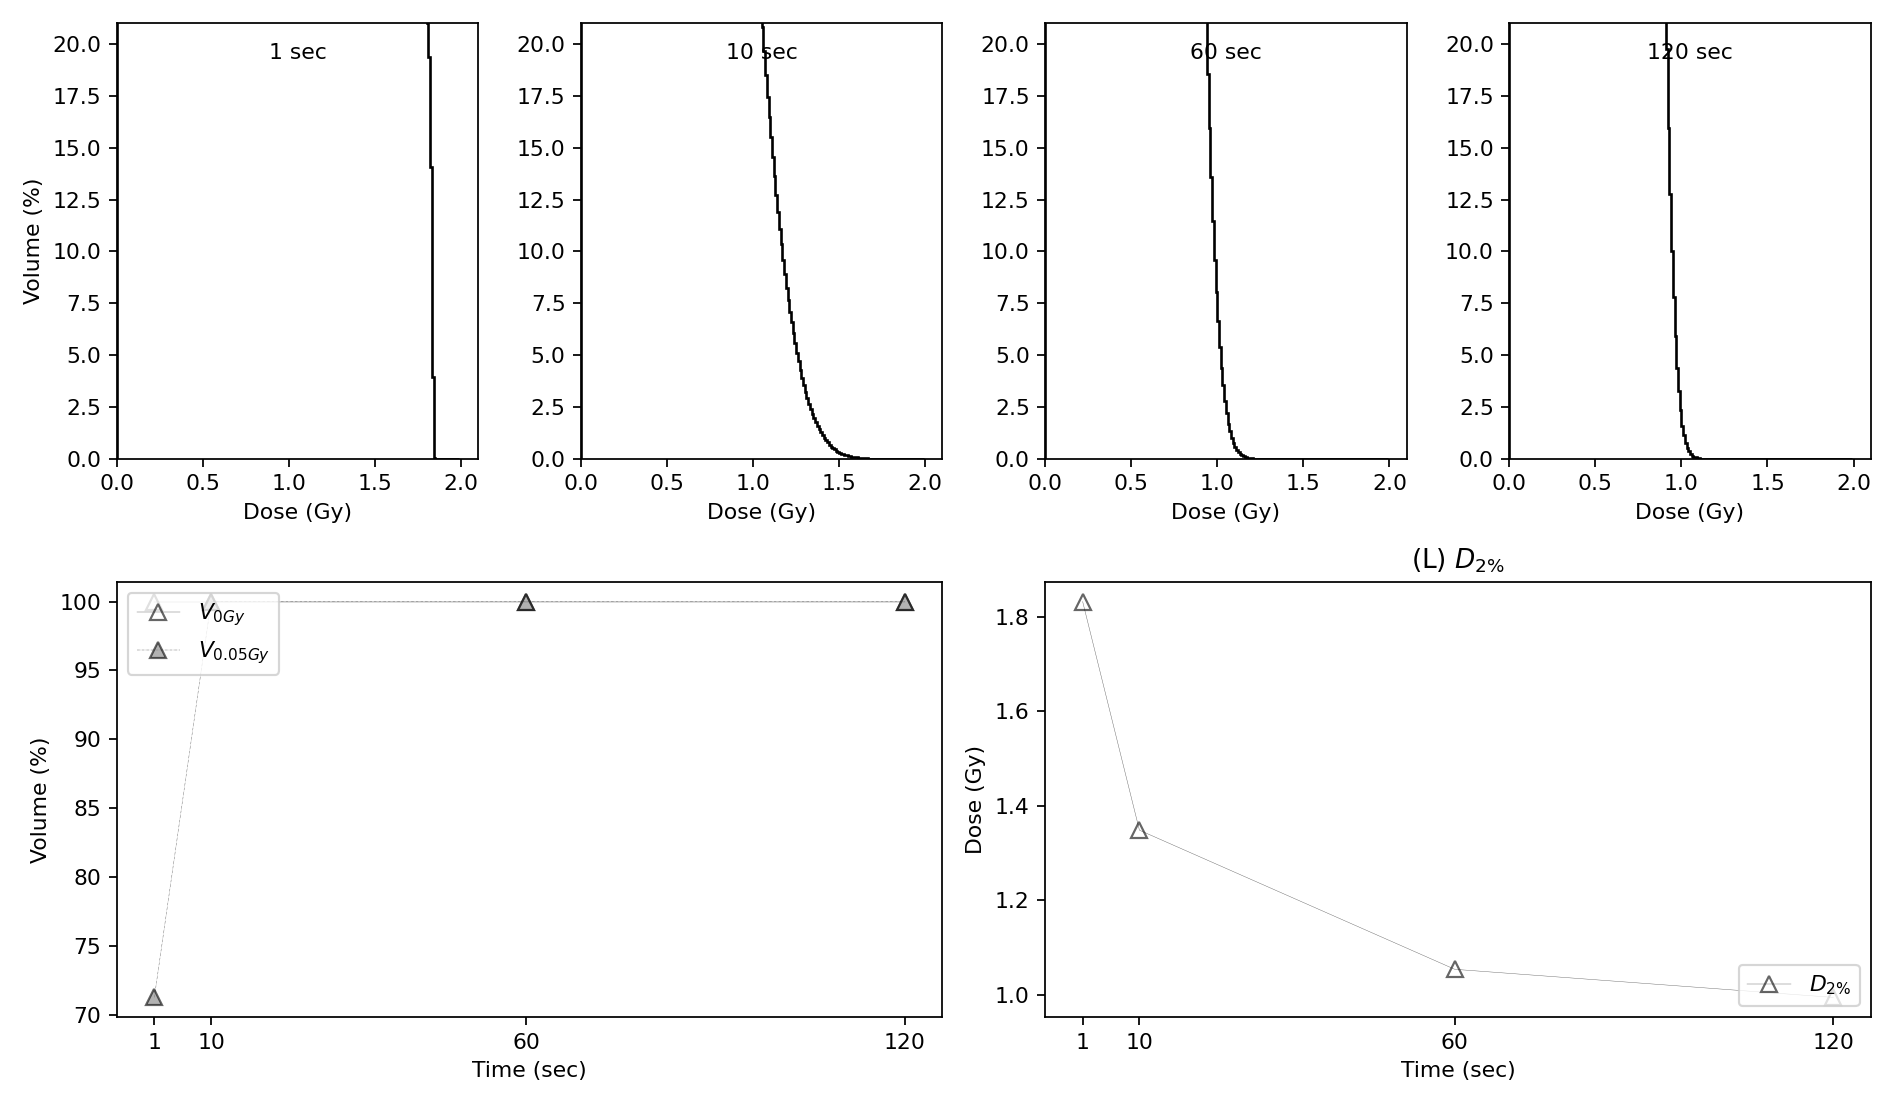

Text(0.5, 1.0, '(L) $D_{2\\%}$')

In [34]:
# Brain field : delivery time dependencies
# 1st row: BDVHs of 1 sec, 2 sec, 10 sec, 60 sec, and 120 sec.
# 2nd row: V0Gy and mean dose
# 3rd row: V0.5Gy and mean dose
# 4th row: D2% and mean dose
# 5th row: D3% and mean dose

delivery_time        = np.array([1, 10, 60, 120])
delivery_time_label  = ["1", "10", "60", "120"]

total_nb_particles = 100_000

Target   = Brain # Brain, Liver
site     = 'brain'
#my_bins  = np.arange(0.0, 3.8, 0.01) # Liver
my_bins   = np.arange(0.0, 2.0, 0.01) # Brain

fig = plt.figure(figsize=(12,7)) 
fig.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.tight_layout()
img_grid = (2,4)

ax1 = [ plt.subplot2grid(img_grid, (0, i)) for i in range(4) ] 
ax1[0].set_xlabel("Dose (Gy)", fontsize=10)
ax1[1].set_xlabel("Dose (Gy)", fontsize=10)
ax1[2].set_xlabel("Dose (Gy)", fontsize=10)
ax1[3].set_xlabel("Dose (Gy)", fontsize=10)
ax1[0].set_ylabel("Volume (%)", fontsize=10)
#ax1[1].set_ylabel("Volume (%)", fontsize=10)
#ax1[2].set_ylabel("Volume (%)", fontsize=10)
#ax1[3].set_ylabel("Volume (%)", fontsize=10)

kwargs_m = dict(edgecolor='k', linewidth=1.2, linestyle='-' , bins=my_bins, cumulative=-1, histtype='step')
kwargs_w = dict(edgecolor='k', linewidth=1.2, linestyle='-', bins=my_bins, cumulative=-1, histtype='step')

# 1 sec
t_id = 0
dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles, label="Constant")
#dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

# 10 sec
t_id = 1
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles)
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

# 60 sec
t_id = 2
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles)
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

# 120 sec
t_id = 3
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles)
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

#ax1[0].legend(loc='center')

# Liver fixed axes : presentation
#ax1[0].set_xlim([0.0, 3.7]) 
#ax1[1].set_xlim([0.0, 3.7]) 
#ax1[2].set_xlim([0.0, 3.7]) 
#ax1[3].set_xlim([0.0, 3.7]) 
#ax1[0].set_ylim([0.0, 51]) 
#ax1[1].set_ylim([0.0, 51]) 
#ax1[2].set_ylim([0.0, 51]) 
#ax1[3].set_ylim([0.0, 51]) 
# Liver varying axes : paper
#ax1[0].set_xlim([0.0, 4.1]) 
#ax1[1].set_xlim([0.0, 2.2]) 
#ax1[2].set_xlim([0.0, 0.8]) 
#ax1[3].set_xlim([0.0, 0.6]) 

# Brain fixed axes : presentation
ax1[0].set_xlim([0.0, 2.1]) 
ax1[1].set_xlim([0.0, 2.1]) 
ax1[2].set_xlim([0.0, 2.1]) 
ax1[3].set_xlim([0.0, 2.1]) 
ax1[0].set_ylim([0.0, 21]) 
ax1[1].set_ylim([0.0, 21]) 
ax1[2].set_ylim([0.0, 21]) 
ax1[3].set_ylim([0.0, 21]) 
# brain
#ax1[0].set_xlim([0.0, 2.1]) 
#ax1[1].set_xlim([0.0, 1.2]) 
#ax1[2].set_xlim([0.0, 0.3]) 
#ax1[3].set_xlim([0.0, 0.3]) 

txt_time1   = AnchoredText("1 sec", loc=9, frameon=False)
txt_time10  = AnchoredText("10 sec", loc=9, frameon=False)
txt_time60  = AnchoredText("60 sec", loc=9, frameon=False)
txt_time120 = AnchoredText("120 sec", loc=9, frameon=False)
ax1[0].add_artist(txt_time1)
ax1[1].add_artist(txt_time10)
ax1[2].add_artist(txt_time60)
ax1[3].add_artist(txt_time120)

# Volume: V0Gy and its mean
ax2 = plt.subplot2grid(img_grid, (1, 0), colspan=2) 
ax2.set_xticks(delivery_time)
ax2.set_xticklabels(delivery_time_label)

k_M = dict(alpha=0.6, markersize=7, marker='o', mec='k', linewidth=0.2, color='k')
k_W = dict(alpha=0.6, markersize=7, marker='^', mec='k', linewidth=0.2, color='k')

m = BDVH_dT[(BDVH_dT['site']==site)&(BDVH_dT['P']==0)] 
w = BDVH_dT[(BDVH_dT['site']==site)&(BDVH_dT['P']==1)] 
#ax2.plot(m['T'].values , m['V0'].values, **k_M, mfc='none', label=r'Constant, $V_{0Gy}$') 
ax2.plot(w['T'].values , w['V0'].values, **k_W, mfc='none', label=r'$V_{0Gy}$') 

# Volume: V0.05 Gy
#ax2 = plt.subplot2grid(img_grid, (1, 4), colspan = 4, sharex=ax2)
#ax2.plot(m['T'].values , m['V0.05'].values, **k_M, mfc='gray', linestyle='-.', label=r'Constant, $V_{0.05Gy}$') 
ax2.plot(w['T'].values , w['V0.05'].values, **k_W, mfc='gray', linestyle='-.', label=r'$V_{0.05Gy}$') 

# Brain
ax2.legend(loc='upper left')
# Liver
#ax2.legend(loc='lower right')
#ax2.set_title(r"(K) $V_{0Gy}$ and $V_{0.05Gy}$")

# Dose: D2%
ax4 = plt.subplot2grid(img_grid, (1, 2), colspan=2, sharex=ax2)

#ax4.plot(m['T'].values , m['D2%'].values, **k_M, mfc='none', label='Constant') 
ax4.plot(w['T'].values , w['D2%'].values, **k_W, mfc='none', label="$D_{2\%}$") 
ax4.legend(loc='lower right')

ax2.set_ylabel("Volume (%)")
ax2.set_xlabel("Time (sec)")

ax4.set_ylabel("Dose (Gy)")
ax4.set_xlabel("Time (sec)")
ax4.set_title(r"(L) $D_{2\%}$")

#fig.savefig(top_dir+"results/liver_bdvh_delivery_time_w2_adjusted_mar29_G_L_aapm.png", dpi=300)
#fig.savefig(top_dir+"results/brain_bdvh_delivery_time_w2_adjusted_mar29_G_L_aapm_b.png", dpi=300)
#fig.savefig(top_dir+"results/liver_bdvh_delivery_time_w2_adjusted_mar29_G_L.png", dpi=300)
#fig.savefig(top_dir+"results/brain_bdvh_delivery_time_w2_adjusted_mar29.png", dpi=300)

# draw_dvh(ax1[0], markov, label="")
# draw_dvh(ax1[0], W1, label="" )


<IPython.core.display.Javascript object>


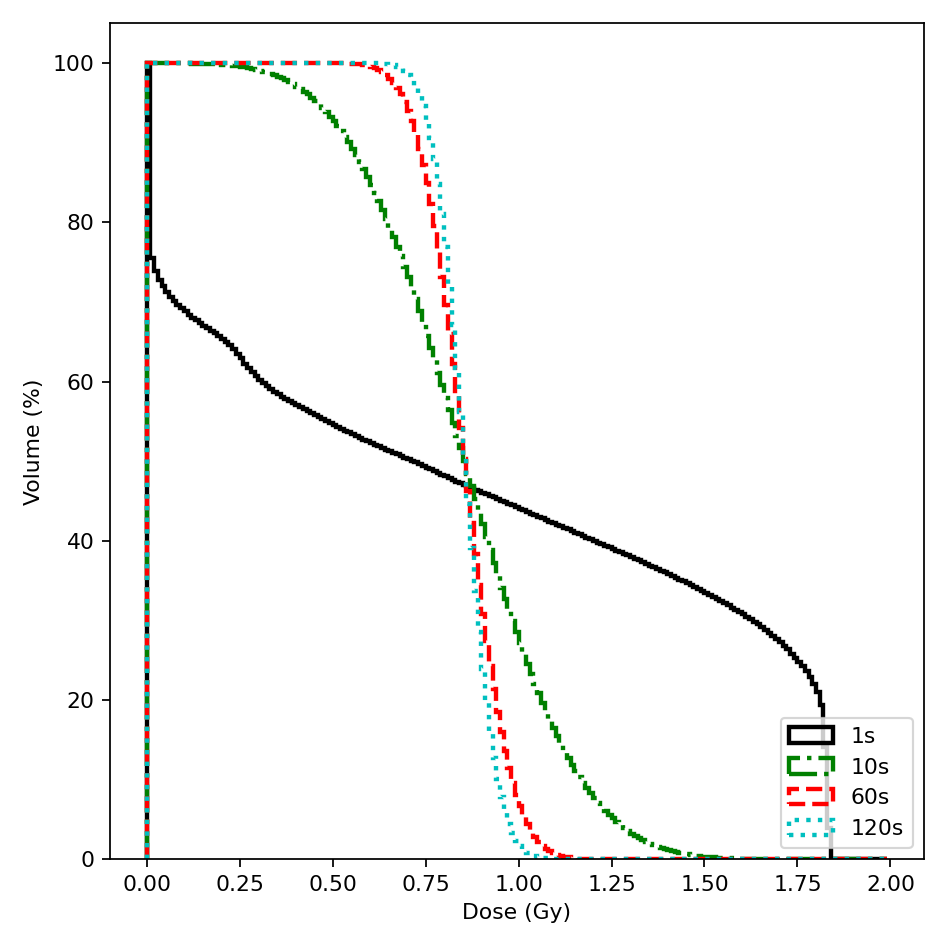

In [33]:
# bDVH in one plot for Liver and Brain

Target   = Brain # Brain, Liver
#my_bins  = np.arange(0.0, 3.8, 0.01) # Liver
my_bins   = np.arange(0.0, 2.0, 0.01) # Brain
total_nb_particles = 100_000
fig = plt.figure(figsize=(6,6)) 
fig.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.tight_layout()
img_grid = (1,1)

ax1 = plt.subplot2grid(img_grid, (0, 0))

ax1.set_xlabel("Dose (Gy)", fontsize=10)
ax1.set_ylabel("Volume (%)", fontsize=10)
#ax1[1].set_ylabel("Volume (%)", fontsize=10)
#ax1[2].set_ylabel("Volume (%)", fontsize=10)
#ax1[3].set_ylabel("Volume (%)", fontsize=10)

kwargs_m = dict(edgecolor='k', linewidth=1.5, bins=my_bins, cumulative=-1, histtype='step')
kwargs_w = dict(linewidth=2.0, bins=my_bins, cumulative=-1, histtype='step')

# 1 sec
t_id = 0
dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
a = ax1.hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle='-', edgecolor='k', label='1s')

# 10 sec
t_id = 1
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1.hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle='-.', edgecolor='g', label='10s')

# 60 sec
t_id = 2
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1.hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle='--', edgecolor='r', label='60s')

# 120 sec
t_id = 3
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1.hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle='dotted', edgecolor='c', label='120s')

ax1.legend(loc='lower right')

#fig.savefig(top_dir+"results/brain_bdvh_delivery_time_w2_adjusted_mar29_G_L_aapm_c.png", dpi=300)
#fig.savefig(top_dir+"results/liver_bdvh_delivery_time_w2_adjusted_mar29_G_L_aapm_c.png", dpi=300)

In [19]:
# tDVH with break between beams.

beam_on_time_liver = 30.0  # 60 has bounds-off at 60 sec
beam_on_time_brain = 10.0  # 20.0 has bounds-off
beam_off_time  = np.array([0, 30, 60, 90])
start_time     = 30

Brain_tDVH = [tDVH(), tDVH(),tDVH(),tDVH(), tDVH()] 
Liver_tDVH = [tDVH(), tDVH(),tDVH(),tDVH(), tDVH()]

Liver_bin_DVH = LiverDVH[1:]
Brain_bin_DVH = BrainDVH[1:]
#print("brain size", len(Brain_bin_DVH))

for j, t in enumerate(beam_off_time):
    # Liver
    for i, l in enumerate(Liver_bin_DVH):
        Liver_tDVH[j].add_array(beam_on_time_liver, l) # bin_DVHs
        if i < len(Liver_bin_DVH) -1 and t > 0:
            #print("liver", t, i)
            Liver_tDVH[j].add(t, None) # No beam
        
    # Brain
    for i, l in enumerate(Brain_bin_DVH):
        Brain_tDVH[j].add_array(beam_on_time_brain, l) # bin_DVHs
        if i < len(Brain_bin_DVH)-1 and t > 0:
            #print("brain", t, i)
            Brain_tDVH[j].add(t, None) # No beam
    
import pandas as pd

BDVH_dT = pd.DataFrame(columns=['site' , 'T', 'P',
                                 'V0'   ,'V0_Dmean'   , 'V0_Dstd',
                                 'V0.05','V0.05_Dmean', 'V0.05_Dstd',
                                 'D2%'  ,'D2%_Dmean'  , 'D2%_Dstd',
                                 'D3%'  ,'D3%_Dmean'  , 'D3%_Dstd'])

Brain = [[ bDVH(BP_m.df, BP_m.dt)  , bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt) ], # 1-row: markov
         [ bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt) ]] # 2-row: Weibull

Liver = [[ bDVH(BP_m.df, BP_m.dt)  , bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt), bDVH(BP_m.df, BP_m.dt) ], # 1-row: markov
         [ bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt), bDVH(BP_w2.df, BP_w2.dt) ]] # 2-row: Weibull


#Brain[0][0] ~ Brain[0][4] : Markov path and delivery 1 sec to 120 sec
#Brain[1][0] ~ Brain[1][4] : Weibull path and delivery 1 sec to 120 sec

# Dose-rate
# composite field but different delivery time
for i in range(2):
    # i = 0 : markov
    # i = 1 : Weibull, k=2
    for j, t in enumerate(beam_off_time):
        print(j,t)
        Brain[i][j].add_dose(Brain_tDVH[j], 0, start_time) # 0 : Brain
        
        d0 = Brain[i][j].volume_gt_dose(0.0)
        d1 = Brain[i][j].volume_gt_dose(0.05)
        v0 = Brain[i][j].dose_at_top_volume(2.0)
        v1 = Brain[i][j].dose_at_top_volume(3.0)


        BDVH_dT = BDVH_dT.append({ 'site': 'brain', 'T'  : t,  'P' : i, 
                                     'V0'    : d0[0], 'V0_Dmean'    : d0[1], 'V0_Dstd'   : d0[2], 
                                     'V0.05' : d1[0], 'V0.05_Dmean' : d1[1], 'V0.05_Dstd': d1[2],
                                     'D2%'   : v0[0], 'D2%_Dmean'   : v0[1], 'D2%_Dstd'  : v0[2],
                                     'D3%'   : v1[0], 'D3%_Dmean'   : v1[1], 'D3%_Dstd'  : v1[2]},ignore_index=True)
# For Liver        
for i in range(2):
    # i = 0 : markov
    # i = 1 : Weibull, k=2
    for j, t in enumerate(beam_off_time):
        print(j,t)
        Liver[i][j].add_dose(Liver_tDVH[j], 18, start_time) # 18: Liver
        
        d0 = Liver[i][j].volume_gt_dose(0.0)
        d1 = Liver[i][j].volume_gt_dose(0.05)
        v0 = Liver[i][j].dose_at_top_volume(2.0)
        v1 = Liver[i][j].dose_at_top_volume(3.0)


        BDVH_dT = BDVH_dT.append({ 'site': 'liver', 'T'  : t,  'P' : i, 
                                     'V0'    : d0[0], 'V0_Dmean'    : d0[1], 'V0_Dstd'   : d0[2], 
                                     'V0.05' : d1[0], 'V0.05_Dmean' : d1[1], 'V0.05_Dstd': d1[2],
                                     'D2%'   : v0[0], 'D2%_Dmean'   : v0[1], 'D2%_Dstd'  : v0[2],
                                     'D3%'   : v1[0], 'D3%_Dmean'   : v1[1], 'D3%_Dstd'  : v1[2]},ignore_index=True)
       
#BDVH_dT.to_excel("paper_beam_sequence_0_5_10_20_30_w2_adjusted.xlsx", sheet_name="beamsequence", index=False)


0 0
1 30
2 60
3 90
0 0
1 30
2 60
3 90
0 0
1 30
2 60
3 90
0 0
1 30
2 60
3 90


In [168]:
BDVH_dT

,site,T,P,V0,V0_Dmean,V0_Dstd,V0.05,V0.05_Dmean,V0.05_Dstd,D2%,D2%_Dmean,D2%_Dstd,D3%,D3%_Dmean,D3%_Dstd
0,brain,0,0,14.445,0.070077,0.067721,7.410,0.116390,0.065720,0.137949,0.202655,0.064413,0.112672,0.176444,0.064478
1,brain,30,0,18.532,0.054720,0.048312,8.271,0.096781,0.041887,0.119841,0.157819,0.033493,0.100531,0.142020,0.035463
2,brain,60,0,18.698,0.054817,0.048474,8.351,0.096657,0.042636,0.119909,0.158830,0.035564,0.100847,0.142751,0.037020
3,brain,90,0,18.740,0.054320,0.048386,8.298,0.096656,0.042279,0.119728,0.157781,0.035743,0.100314,0.141951,0.036923
4,brain,0,1,11.768,0.088613,0.053940,8.924,0.108088,0.046881,0.136672,0.177903,0.039977,0.117751,0.160639,0.040890
5,brain,30,1,15.620,0.064632,0.047512,8.957,0.095141,0.039798,0.118691,0.154607,0.035660,0.101811,0.139877,0.035911
6,brain,60,1,16.271,0.063650,0.046621,9.199,0.094336,0.038833,0.118513,0.153232,0.034570,0.102412,0.138954,0.034811
7,brain,90,1,16.096,0.063455,0.045990,9.134,0.093704,0.037945,0.117881,0.151325,0.032825,0.101061,0.137441,0.033344
8,liver,0,0,37.313,0.230003,0.213100,31.059,0.274465,0.206684,0.652422,0.803534,0.125830,0.576484,0.739717,0.137325
9,liver,30,0,42.004,0.203571,0.181620,34.520,0.245723,0.173550,0.565752,0.693476,0.120293,0.510131,0.640555,0.123822


<IPython.core.display.Javascript object>


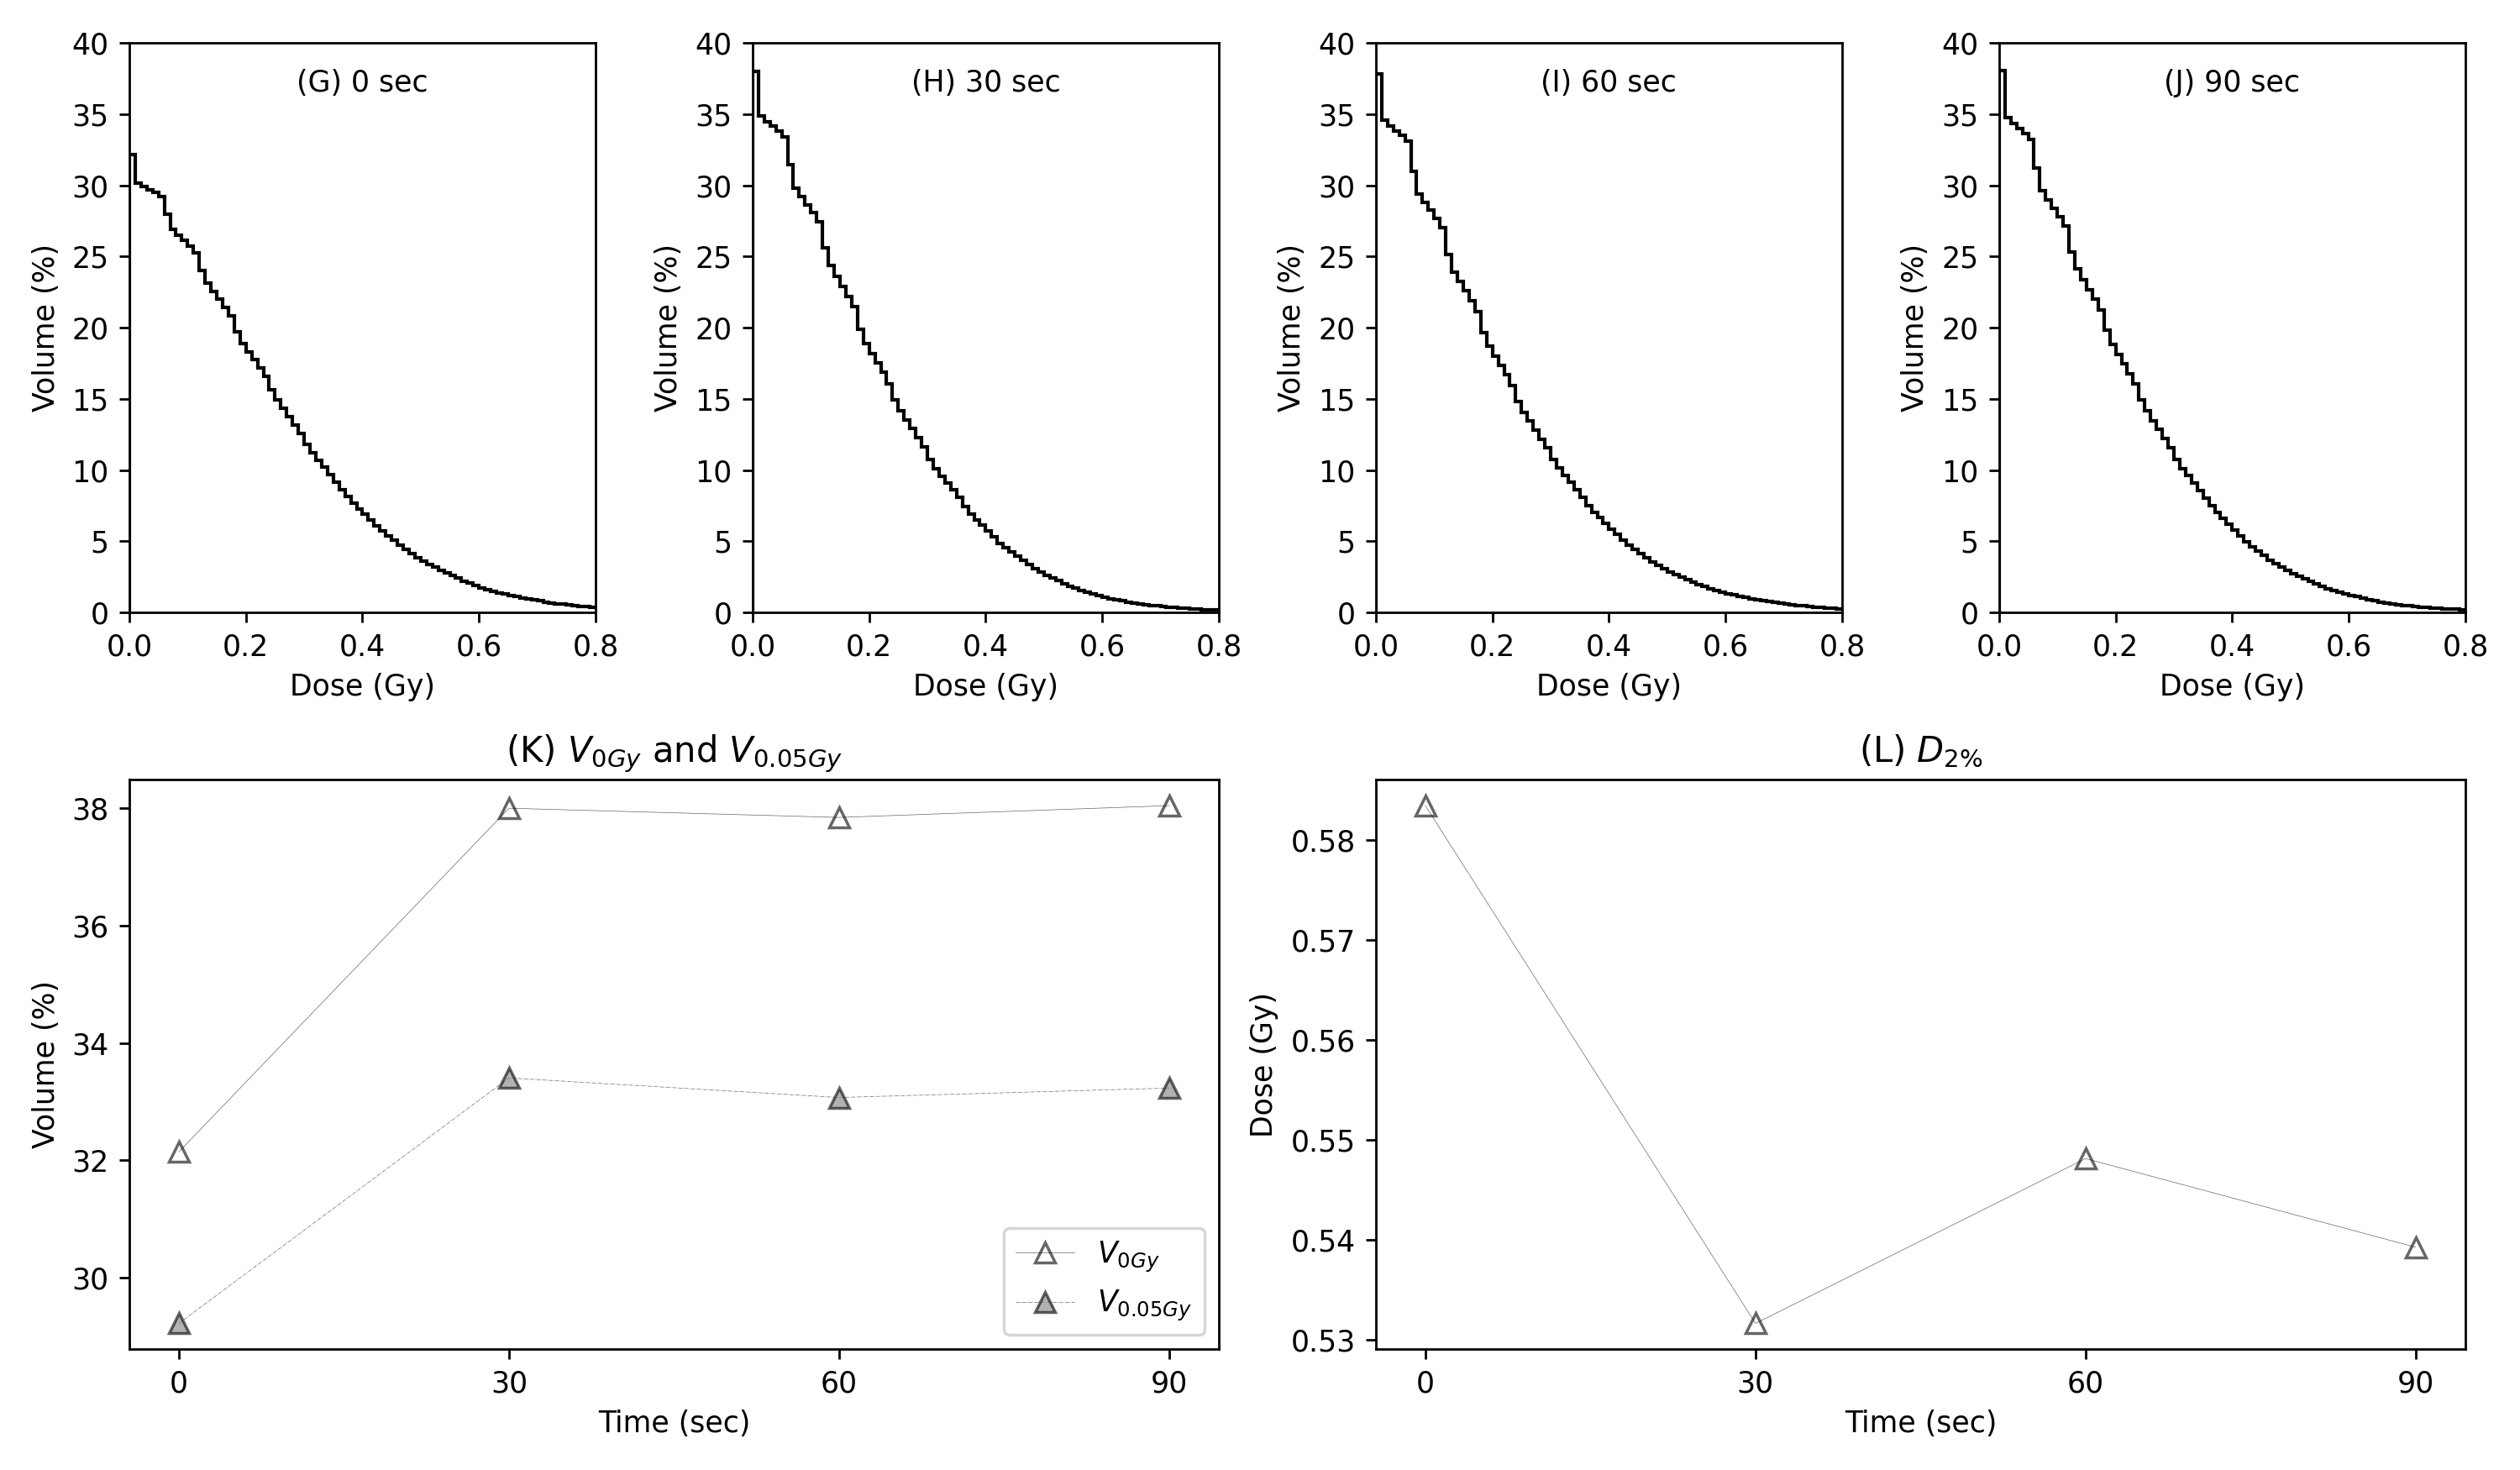

In [20]:
# bDVH for beam sequence

# Brain field : delivery time dependencies
# 1st row: BDVHs of 1 sec, 2 sec, 10 sec, 60 sec, and 120 sec.
# 2nd row: V0Gy and mean dose
# 3rd row: V0.5Gy and mean dose
# 4th row: D2% and mean dose
# 5th row: D3% and mean dose

delivery_interval        = np.array([0, 30, 60, 90])
delivery_interval_label  = ["0","30", "60", "90"]

total_nb_particles = 100_000

Target   = Liver # Brain, Liver
site     = 'liver' #brain, liver
my_bins  = np.arange(0.0, 3.8, 0.01) # Liver
#my_bins   = np.arange(0.0, 0.35, 0.01) # Brain

fig = plt.figure(figsize=(12,7)) 
fig.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.tight_layout()
img_grid = (2,4)

ax1 = [ plt.subplot2grid(img_grid, (0, i)) for i in range(4) ] 
ax1[0].set_xlabel("Dose (Gy)", fontsize=10)
ax1[1].set_xlabel("Dose (Gy)", fontsize=10)
ax1[2].set_xlabel("Dose (Gy)", fontsize=10)
ax1[3].set_xlabel("Dose (Gy)", fontsize=10)
ax1[0].set_ylabel("Volume (%)", fontsize=10)
ax1[1].set_ylabel("Volume (%)", fontsize=10)
ax1[2].set_ylabel("Volume (%)", fontsize=10)
ax1[3].set_ylabel("Volume (%)", fontsize=10)

txt_time0   = AnchoredText("(G) 0 sec", loc=9, frameon=False)
txt_time30  = AnchoredText("(H) 30 sec", loc=9, frameon=False)
txt_time60  = AnchoredText("(I) 60 sec", loc=9, frameon=False)
txt_time90  = AnchoredText("(J) 90 sec", loc=9, frameon=False)
ax1[0].add_artist(txt_time0)
ax1[1].add_artist(txt_time30)
ax1[2].add_artist(txt_time60)
ax1[3].add_artist(txt_time90)

kwargs_w = dict(edgecolor='k', linewidth=1.2, linestyle='-' , bins=my_bins, cumulative=-1, histtype='step')
#kwargs_w = dict(edgecolor='gray', linewidth=1.2, linestyle='--', bins=my_bins, cumulative=-1, histtype='step')


# 1 sec
t_id = 0
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles, label="Constant")
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, label="Weibull")

# 10 sec
t_id = 1
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles)
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

# 10 sec
t_id = 2
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles)
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

# 30 sec
t_id = 3
#dose = Target[0][t_id].dose[Target[0][t_id].dose>0.0]
#a = ax1[t_id].hist(dose, **kwargs_m, weights=100.0*np.ones_like(dose)/total_nb_particles)
dose = Target[1][t_id].dose[Target[1][t_id].dose>0.0]
a = ax1[t_id].hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles)

# Brain
#[ ax1[i].set_xlim([0.0, 0.2]) for i in range(4)]
#[ ax1[i].set_ylim([0.0, 20]) for i in range(4)]


# Liver
[ ax1[i].set_xlim([0.0, 0.8]) for i in range(4)]
[ ax1[i].set_ylim([0.0, 40]) for i in range(4)]

#ax1[0].legend(loc='center')

# Volume: V0Gy and its mean
ax2 = plt.subplot2grid(img_grid, (1, 0), colspan=2) 
ax2.set_xticks(beam_off_time)
ax2.set_xticklabels(beam_off_time)

k_M = dict(alpha=0.6, markersize=7, marker='o', mec='k', linewidth=0.2, color='k')
k_W = dict(alpha=0.6, markersize=7, marker='^', mec='k', linewidth=0.2, color='k')

m = BDVH_dT[(BDVH_dT['site']==site)&(BDVH_dT['P']==0)] 
w = BDVH_dT[(BDVH_dT['site']==site)&(BDVH_dT['P']==1)] 

# Volume: V0.05 Gy
#ax2.plot(m['T'].values , m['V0'].values, **k_M, mfc='none', label=r'Constant, $V_{0Gy}$') 
ax2.plot(w['T'].values , w['V0'].values, **k_W, mfc='none', label=r'$V_{0Gy}$') 

# Volume: V0.05 Gy
#ax2.plot(m['T'].values , m['V0.05'].values, **k_M, mfc='gray', linestyle='-.', label=r'Constant, $V_{0.05Gy}$') 
ax2.plot(w['T'].values , w['V0.05'].values, **k_W, mfc='gray', linestyle='-.', label=r'$V_{0.05Gy}$') 

# Brain
#ax2.legend(loc='center')

# Liver
ax2.legend(loc='lower right')

ax2.set_title(r"(K) $V_{0Gy}$ and $V_{0.05Gy}$")

# Dose: D2%
ax4 = plt.subplot2grid(img_grid, (1, 2), colspan=2, sharex=ax2)

#ax4.plot(m['T'].values , m['D2%'].values, **k_M, mfc='none', label='Constant') 
ax4.plot(w['T'].values , w['D2%'].values, **k_W, mfc='none', label='Weibull') 

ax2.set_ylabel("Volume (%)")
ax2.set_xlabel("Time (sec)")

ax4.set_ylabel("Dose (Gy)")
ax4.set_xlabel("Time (sec)")
ax4.set_title(r"(L) $D_{2\%}$")

#fig.savefig(top_dir+"results/brain_bdvh_delivery_sequence_w2_adjusted_mar23.png", dpi=300)
#fig.savefig(top_dir+"results/liver_bdvh_delivery_sequence_w2_adjusted_mar23_G_L.png", dpi=300)



In [64]:
import pandas as pd

print(top_dir)

delivery_time  = 60
start_time     = 30

Brain_tDVH = tDVH()
Liver_tDVH = tDVH()

Brain_tDVH.add_array(delivery_time, BrainDVH[0])
Liver_tDVH.add_array(delivery_time, LiverDVH[0])

Brain = bDVH(BP_w2.df, BP_w2.dt) 
Liver = bDVH(BP_w2.df, BP_w2.dt)

Brain.add_dose(Brain_tDVH, 0, start_time, delivery["brain"][1]) # 0 : Brain
#Brain.dose_per_fraction.tofile(top_dir+ 'brain_m_33fx_feb18.bin')

print(Brain.dose_per_fraction.shape)
Brain_acc = np.zeros_like(Brain.dose_per_fraction)
for col in range(Brain_acc.shape[1]):
    Brain_acc[0:, col] = Brain.dose_per_fraction[0:, 0:col+1].sum(axis=1)

Liver.add_dose(Liver_tDVH, 18, start_time, delivery["liver"][1]) # 18: Liver
#Liver.dose_per_fraction.tofile(top_dir+ 'liver_m_15fx_feb18.bin')

print(Liver.dose_per_fraction.shape)
Liver_acc = np.zeros_like(Liver.dose_per_fraction)
for col in range(Liver_acc.shape[1]):
    Liver_acc[0:, col] = Liver.dose_per_fraction[0:, 0:col+1].sum(axis=1)
   

#BDVH_dT.to_excel("paper_dose_rate.xlsx", sheet_name="delivery_time", index=False)


/Users/jv774/db/publications/markov/analysis/
(100000, 33)
(100000, 15)


In [1]:
### Drawing DVHs (Brain and Liver)

brain_fx_to_display = [1, 10, 20, 33]
liver_fx_to_display = [1, 5, 10, 15]
fx_line_style       = ['-', '--', '-.', ':']

fig = plt.figure(figsize=(8,4)) 
fig.subplots_adjust(wspace=0.05)
img_grid = (1,2)

# Brain BDVH as a function of fraction 
ax1 = plt.subplot2grid(img_grid, (0, 0))

my_bins  = np.arange(0.0, 2.0, 0.01) # Brain
kwargs_b = dict(edgecolor='k', linewidth=1.2 , bins=my_bins, cumulative=-1, histtype='step') #, linestyle='-'

for i, fi in enumerate(brain_fx_to_display):
    dose = Brain_acc[0:,fi-1][ Brain_acc[0:,fi-1] >0.0]
    a = ax1.hist(dose, **kwargs_b, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle=(fx_line_style[i]), label="Fraction"+str(fi))

ax1.set_xlabel("Dose (Gy)")
ax1.set_ylabel("Volume (%)")
ax1.set_xlim([0.0, 1.1])
ax1.set_title("(A) Brain")
ax1.legend(loc='upper right')

# Liver BDVH as a function of fraction
ax2 = plt.subplot2grid(img_grid, (0, 1))
my_bins  = np.arange(0.0, 3.8, 0.01) # Liver
kwargs_w = dict(edgecolor='gray', linewidth=1.2, bins=my_bins, cumulative=-1, histtype='step') #, linestyle='--'

for i, fi in enumerate(liver_fx_to_display):
    dose = Liver_acc[0:,fi-1][ Liver_acc[0:,fi-1] >0.0]
    a = ax2.hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle=(fx_line_style[i]), label="Fraction" + str(fi))

ax2.set_xlim([0.0, 3.5])
ax2.set_xlabel("Dose (Gy)")
ax2.set_ylabel("Volume (%)")
ax2.set_title("(B) Liver")
ax2.legend(loc='upper right')

#plt.savefig(top_dir+"results/bDVH_beam_fractionation.png", dpi=300)


NameError: name 'plt' is not defined

In [67]:
# Print out BDVH metrices as a function of fraction
def volume_gt_dose(dose, threshold):
    """
    threshold: threshold dose (Gy)
    return volume (%) of BP g.t threshold, mean dose, std dose
    """
    # return mean/std of dose?
    bp     = dose[dose  >  threshold]
    bp_vol = 100.0 * bp.size/dose.size
    return bp_vol, bp.mean(), bp.std()

def dose_at_top_volume(dose, threshold, number_of_bps=100_000):
    """
    threshold (%) : upper volume, e.g., 2 for 2 %
    return dose (Gy) at volume, mean dose, std dose
    """
    np_top = int(number_of_bps * threshold * 0.01)
    t = np.sort(dose)
    return t[-np_top], t[-np_top:].mean(), t[-np_top:].std()

BDVH_FX = pd.DataFrame(columns=['site' , 'FX',
                                 'V0'   ,'V0_Dmean'   , 'V0_Dstd',
                                 'V0.05','V0.05_Dmean', 'V0.05_Dstd',
                                 'V0.125','V0.125_Dmean', 'V0.125_Dstd',
                                 'V0.5' ,'V0.5_Dmean' , 'V0.5_Dstd',
                                 'D2%'  ,'D2%_Dmean'  , 'D2%_Dstd',
                                 'D3%'  ,'D3%_Dmean'  , 'D3%_Dstd'])

print("--- Brain ---")
for i, fi in enumerate(brain_fx_to_display):
    T    = Brain_acc[0:, fi - 1] # dose aftr fi-1 fraction
    d0   = volume_gt_dose(T, 0.0)
    d1   = volume_gt_dose(T, 0.05)
    d2   = volume_gt_dose(T, 0.125)
    d3   = volume_gt_dose(T, 0.5)
    v0   = dose_at_top_volume(T, 2.0)
    v1   = dose_at_top_volume(T, 3.0)
    
    BDVH_FX = BDVH_FX.append({ 'site': 'brain', 'FX'  : fi, 
                               'V0'    : d0[0], 'V0_Dmean'    : d0[1], 'V0_Dstd'   : d0[2], 
                               'V0.05' : d1[0], 'V0.05_Dmean' : d1[1], 'V0.05_Dstd': d1[2],
                               'V0.125': d2[0], 'V0.125_Dmean' :d2[1], 'V0.125_Dstd' : d2[2],
                               'V0.5'  : d3[0], 'V0.5_Dmean'  : d3[1], 'V0.5_Dstd' : d3[2],
                               'D2%'   : v0[0], 'D2%_Dmean'   : v0[1], 'D2%_Dstd'  : v0[2],
                               'D3%'   : v1[0], 'D3%_Dmean'   : v1[1], 'D3%_Dstd'  : v1[2]},ignore_index=True)
print(BDVH_FX)
  
print("--- Liver ---")
for i, fi in enumerate(liver_fx_to_display):
    T    = Liver_acc[0:, fi - 1] # dose aftr fi-1 fraction
    d0   = volume_gt_dose(T, 0.0)
    d1   = volume_gt_dose(T, 0.05)
    d2   = volume_gt_dose(T, 0.125)
    d3   = volume_gt_dose(T, 0.5)
    v0   = dose_at_top_volume(T, 2.0)
    v1   = dose_at_top_volume(T, 3.0)
    BDVH_FX = BDVH_FX.append({ 'site': 'liver', 'FX'  : fi, 
                               'V0'    : d0[0], 'V0_Dmean'    : d0[1], 'V0_Dstd'   : d0[2], 
                               'V0.05' : d1[0], 'V0.05_Dmean' : d1[1], 'V0.05_Dstd': d1[2],
                               'V0.125': d2[0], 'V0.125_Dmean' :d2[1], 'V0.125_Dstd' : d2[2],
                               'V0.5'  : d3[0], 'V0.5_Dmean'  : d3[1], 'V0.5_Dstd' : d3[2],
                               'D2%'   : v0[0], 'D2%_Dmean'   : v0[1], 'D2%_Dstd'  : v0[2],
                               'D3%'   : v1[0], 'D3%_Dmean'   : v1[1], 'D3%_Dstd'  : v1[2]},ignore_index=True)

print(BDVH_FX)
#BDVH_FX.to_excel(top_dir+"bdvh_fraction.xlsx", sheet_name="fraction", index=False)


--- Brain ---
    site  FX      V0  V0_Dmean   V0_Dstd   V0.05  V0.05_Dmean  V0.05_Dstd  \
0  brain   1  11.768  0.087708  0.051981   8.862     0.107058    0.044770   
1  brain  10  71.283  0.144795  0.098568  61.412     0.163432    0.093469   
2  brain  20  91.840  0.224770  0.142221  85.887     0.238327    0.137037   
3  brain  33  98.395  0.346163  0.188278  96.336     0.352927    0.184433   

   V0.125  V0.125_Dmean  V0.125_Dstd    V0.5  V0.5_Dmean  V0.5_Dstd       D2%  \
0   2.462      0.165329     0.037548   0.000         NaN        NaN  0.134487   
1  34.780      0.221673     0.085234   0.366    0.558083   0.055318  0.382738   
2  66.289      0.282322     0.125365   4.371    0.592797   0.086137  0.576403   
3  87.974      0.377823     0.173394  19.430    0.635278   0.120723  0.797164   

   D2%_Dmean  D2%_Dstd       D3%  D3%_Dmean  D3%_Dstd  
0   0.173560  0.037052  0.116487   0.157297  0.038122  
1   0.450842  0.062797  0.351974   0.422600  0.065189  
2   0.663443  0.080244  0.

<ipython-input-67-94173981ba9a>:10: RuntimeWarning: Mean of empty slice.
  return bp_vol, bp.mean(), bp.std()
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


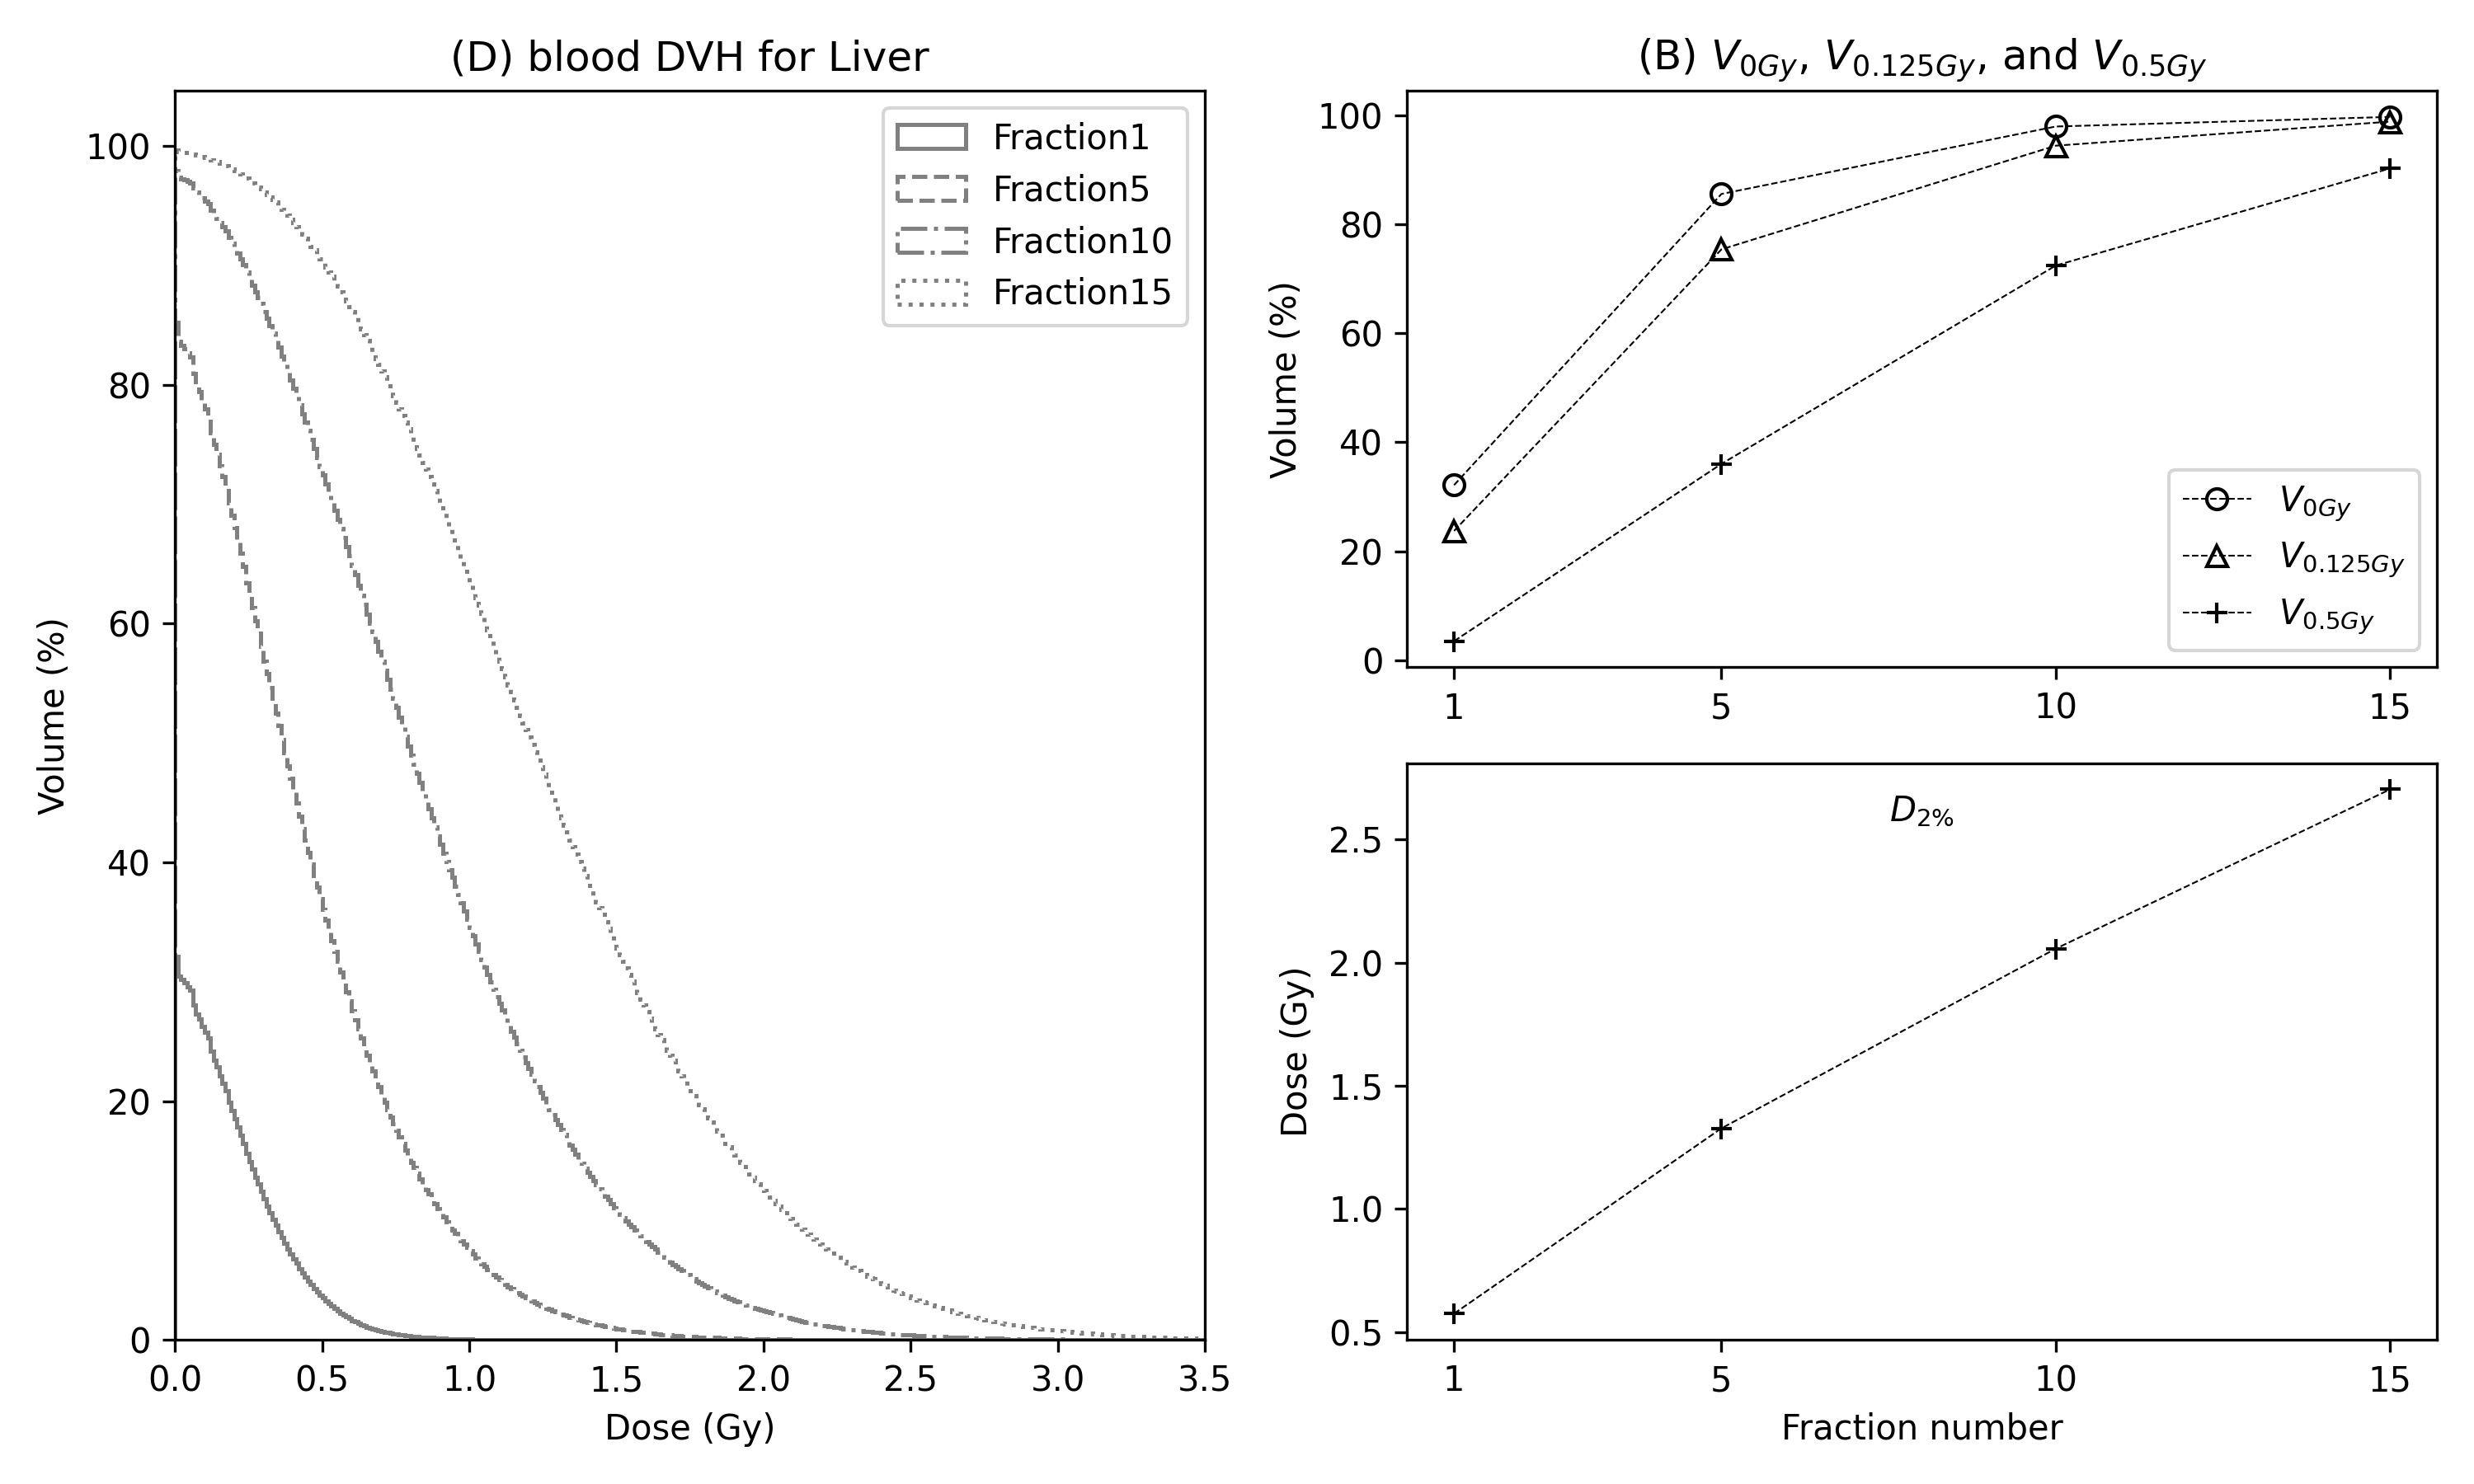

Text(0.5, 1.0, '(B) $V_{0Gy}$, $V_{0.125Gy}$, and $V_{0.5Gy}$')

In [70]:
# For Brain fraction dose

fig = plt.figure(figsize=(10,6)) 
fig.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.tight_layout()
img_grid = (2,2)

ax1 = plt.subplot2grid(img_grid, (0, 0), rowspan=2)


#selected_site = "brain"
#my_bins  = np.arange(0.0, 2.0, 0.01) # Brain
#kwargs_b = dict(edgecolor='k', linewidth=1.2 , bins=my_bins, cumulative=-1, histtype='step') #, linestyle='-'
#for i, fi in enumerate(brain_fx_to_display):
#    dose = Brain_acc[0:,fi-1][ Brain_acc[0:,fi-1] >0.0]
#    a = ax1.hist(dose, **kwargs_b, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle=(fx_line_style[i]), label="Fraction"+str(fi))

selected_site = "liver"
my_bins  = np.arange(0.0, 3.8, 0.01) # Liver
kwargs_w = dict(edgecolor='gray', linewidth=1.2, bins=my_bins, cumulative=-1, histtype='step') #, linestyle='--'
for i, fi in enumerate(liver_fx_to_display):
    dose = Liver_acc[0:,fi-1][ Liver_acc[0:,fi-1] >0.0]
    a = ax1.hist(dose, **kwargs_w, weights=100.0*np.ones_like(dose)/total_nb_particles, linestyle=(fx_line_style[i]), label="Fraction" + str(fi))

ax1.set_xlabel("Dose (Gy)")
ax1.set_ylabel("Volume (%)")
#ax1.set_xlim([0.0, 1.1]) #Brain
ax1.set_xlim([0.0, 3.5]) #liver
#ax1.set_title("(A) blood DVH for Brain")
ax1.set_title("(D) blood DVH for Liver")
ax1.legend(loc='upper right')

br_fx = BDVH_FX[BDVH_FX.site==selected_site]

# D2%
ax3 = plt.subplot2grid(img_grid, (1, 1))
ax3.plot(br_fx["FX"].values, br_fx["D2%"].values, "k+--", linewidth=0.5)
#Brain
#ax3.set_xticks(brain_fx_to_display)
#ax3.set_xticklabels(brain_fx_to_display)
#Liver
ax3.set_xticks(liver_fx_to_display)
ax3.set_xticklabels(liver_fx_to_display)
ax3.set_xlabel("Fraction number")
ax3.set_ylabel("Dose (Gy)")

txt_d2p = AnchoredText(r"$(C) D_{2\%}$", loc=9, frameon=False)
ax3.add_artist(txt_d2p)

# V0gy
ax2 = plt.subplot2grid(img_grid, (0, 1), sharex=ax3)

ax2.plot(br_fx["FX"].values, br_fx["V0"].values, "ko--", linewidth=0.5, mfc='none', label=r"$V_{0Gy}$")
ax2.plot(br_fx["FX"].values, br_fx["V0.125"].values, "k^--", linewidth=0.5,mfc='none', label=r"$V_{0.125Gy}$")
ax2.plot(br_fx["FX"].values, br_fx["V0.5"].values, "k+--", linewidth=0.5,mfc='none', label=r"$V_{0.5Gy}$")
#brain
#ax2.legend(loc="right")
#liver
ax2.legend(loc="lower right")
ax2.set_ylabel(r"Volume (%)")
ax2.set_title(r"(B) $V_{0Gy}$, $V_{0.125Gy}$, and $V_{0.5Gy}$")

#plt.savefig(top_dir+"results/bDVH_fractionation_brain_v4_A_C.png", dpi=300)
#plt.savefig(top_dir+"results/bDVH_fractionation_liver_v4_D_F.png", dpi=300)


<IPython.core.display.Javascript object>


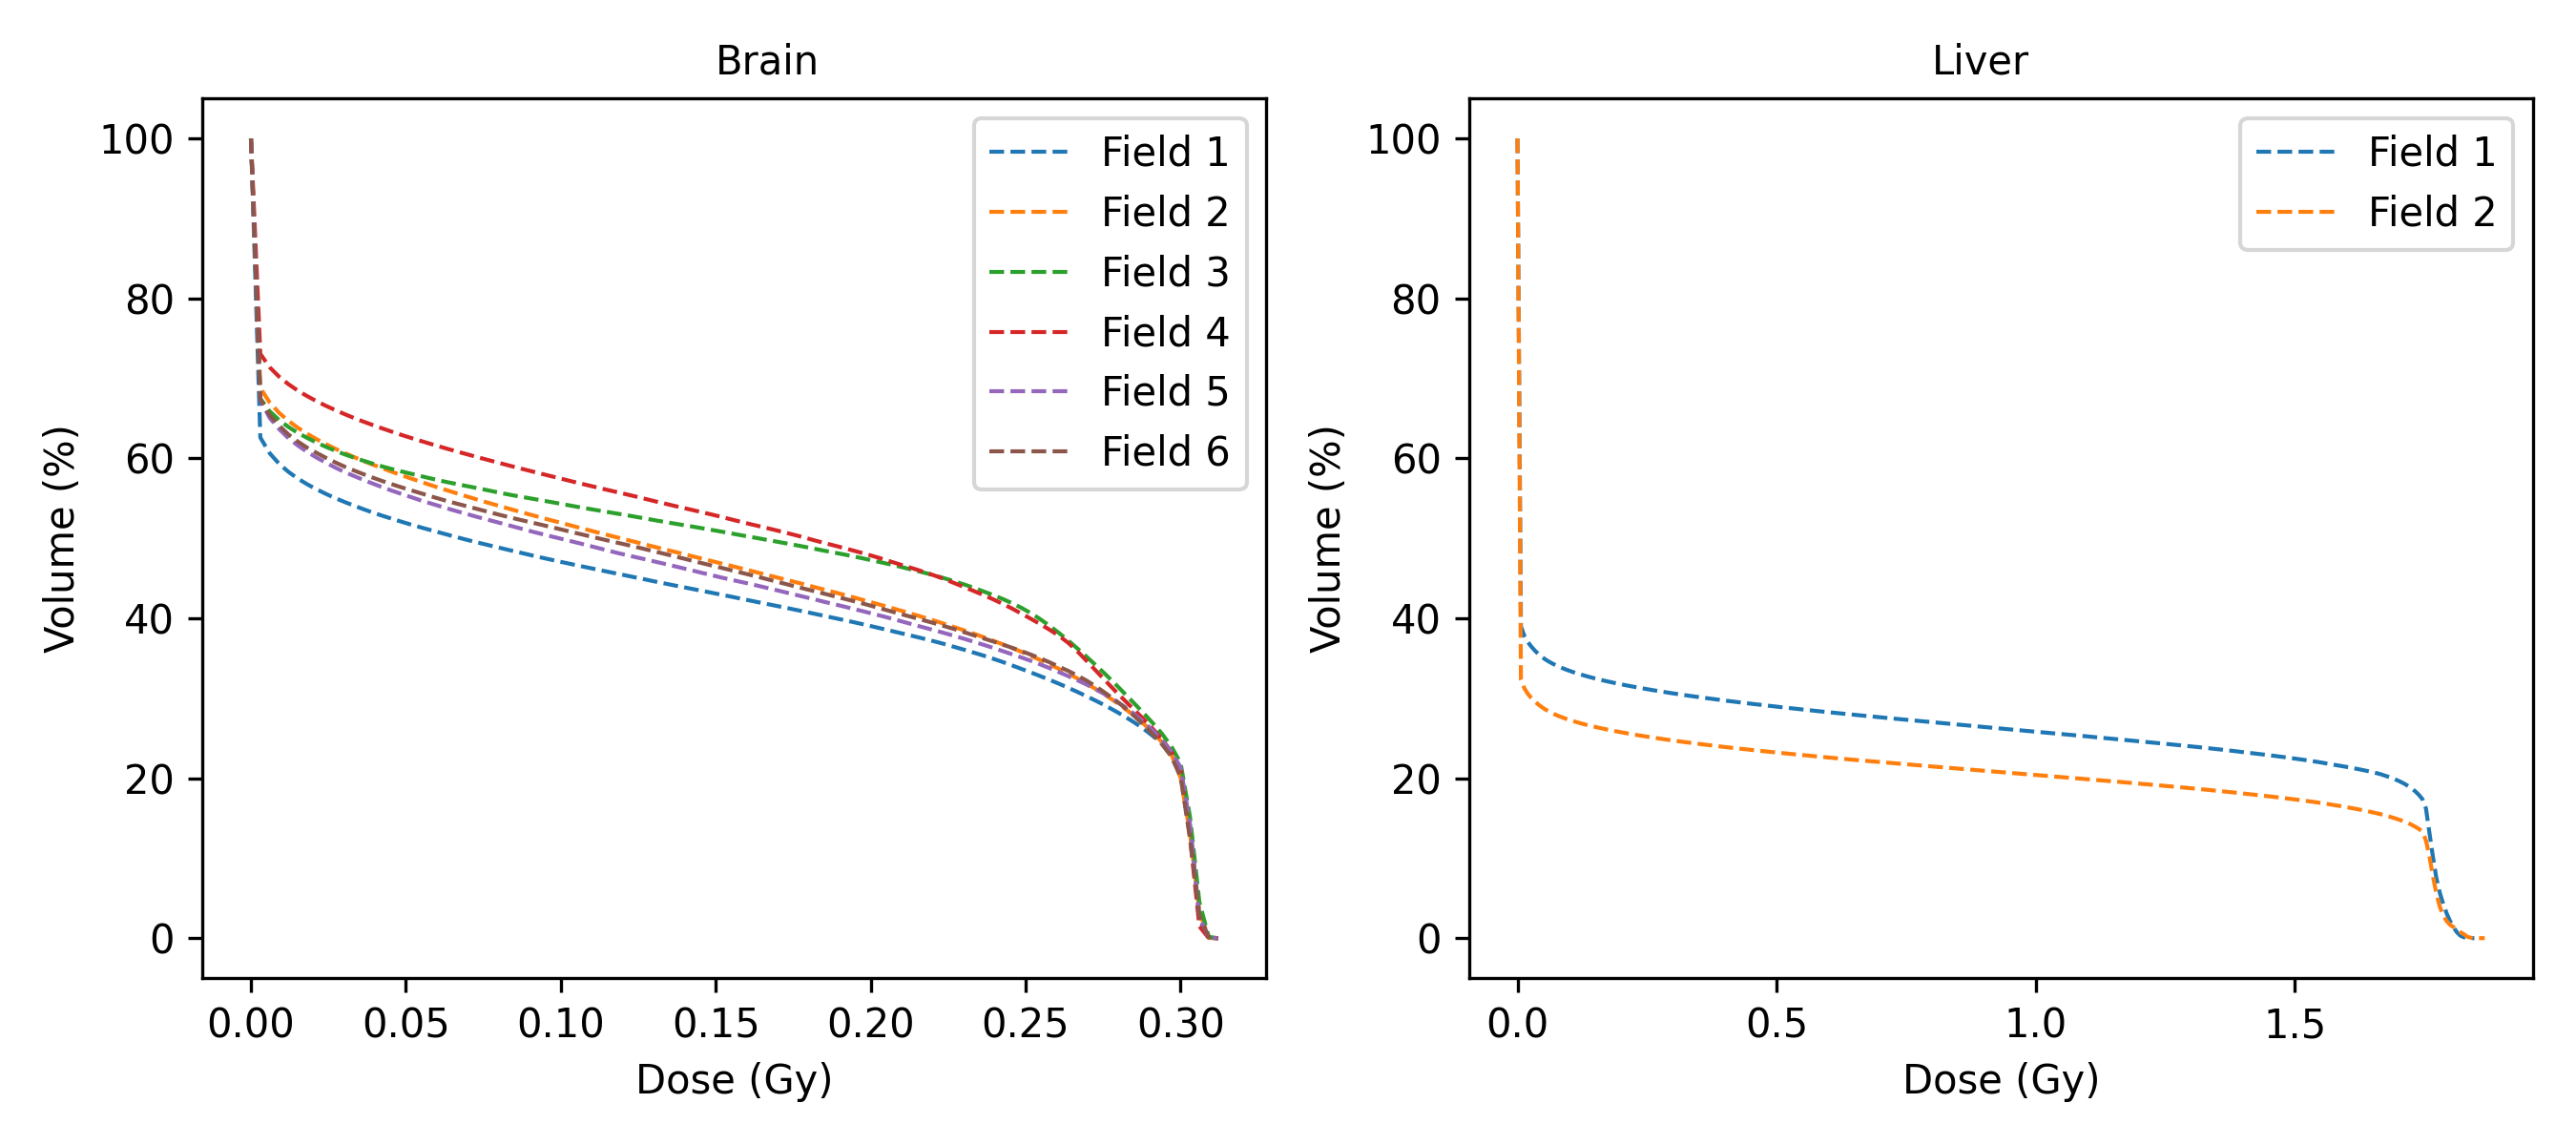

Text(0.8, 108, 'Liver')

In [30]:
### Drawing DVHs (Brain and Liver)

fig = plt.figure(figsize=(9,4)) 
fig.subplots_adjust(wspace=0.05)
img_grid = (1,2)

# Brain
ax1 = plt.subplot2grid(img_grid, (0, 0))
for i,d in enumerate(BrainDVH):
    if i == 0 :
        None
        #ax1.plot(d[0:,0], d[0:,1], 'k-', linewidth=1.5, label="Composite")
    else:
        ax1.plot(d[0:,0], d[0:,1], linewidth=1.0, linestyle='--', label="Field {}".format(i))
ax1.legend(loc='upper right')
ax1.set_xlabel("Dose (Gy)")
ax1.set_ylabel("Volume (%)")

# Liver
ax2 = plt.subplot2grid(img_grid, (0, 1))
for i,d in enumerate(LiverDVH):
    if i == 0 :
        None
        #ax2.plot(d[0:,0], d[0:,1], 'k-', linewidth=1.5, label="Composite")
    else:
        ax2.plot(d[0:,0], d[0:,1], linewidth=1.0, linestyle='--', label="Field {}".format(i))
ax2.legend(loc='upper right')
ax2.set_xlabel("Dose (Gy)")
ax2.set_ylabel("Volume (%)")

#ax1.text(0.8, 108,"Brain", color='k', fontsize=10)
#ax2.text(1.6, 108 ,"Liver", color='k', fontsize=10)

# net_time_to_deliver_composite is sum of net time of field 1 and field 2? then, I think composite dose is enough
#plt.savefig(top_dir+"results/dose_dvh_jennifer_all_label.png", dpi=300)

<IPython.core.display.Javascript object>


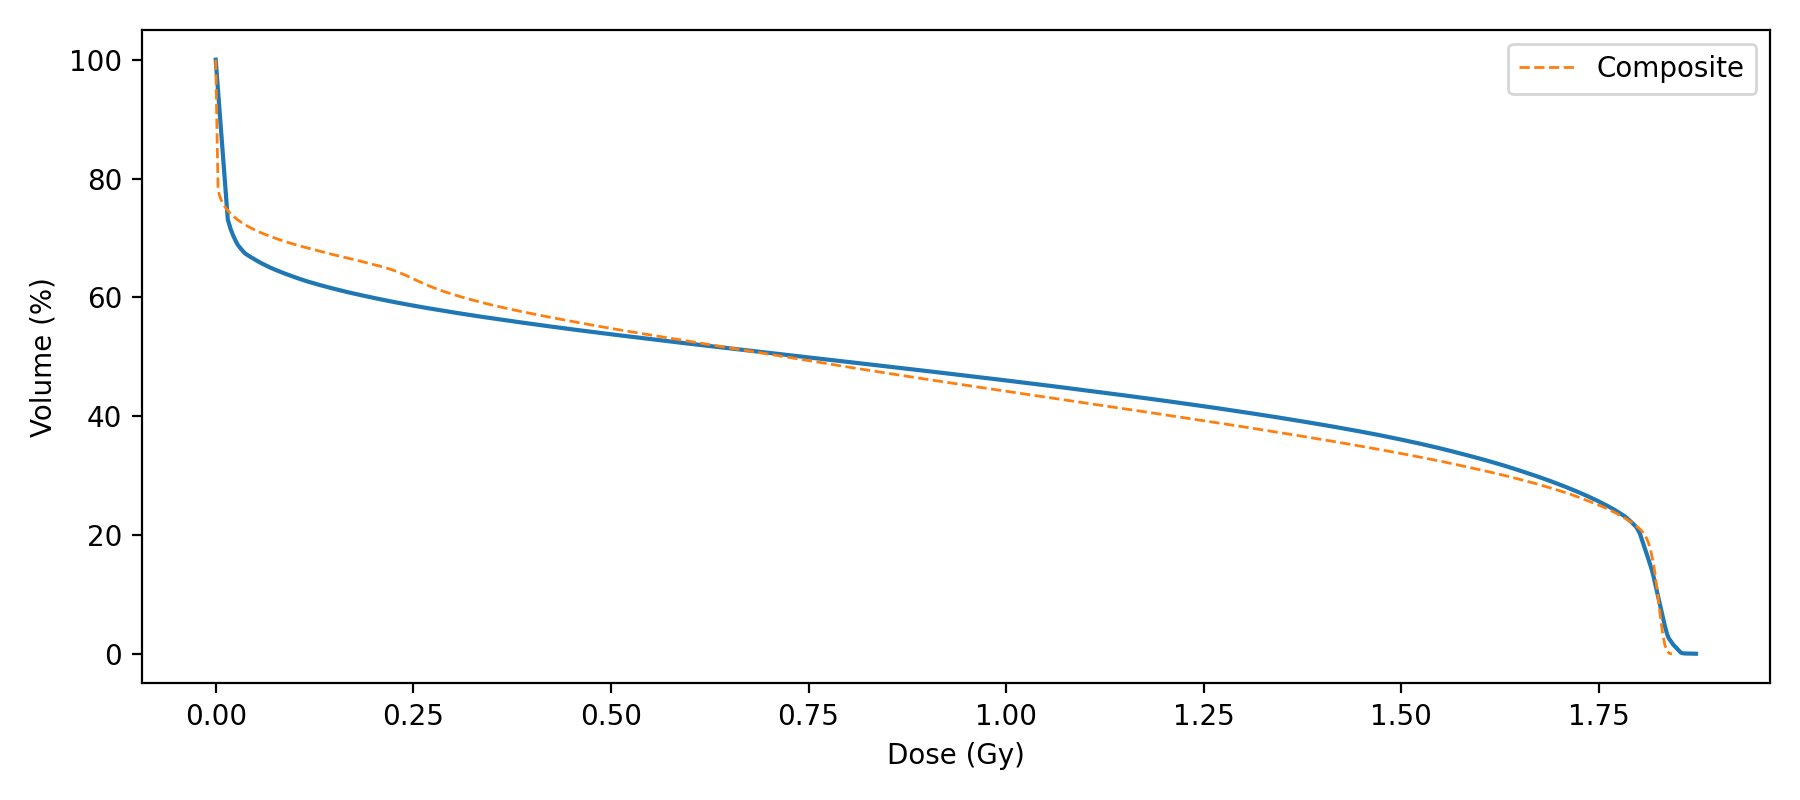

Text(0, 0.5, 'Volume (%)')

In [173]:
# To check sum of fields = Composite in DVH
# D(v)
DB1 = interp1d(BrainDVH[1][0:,1], BrainDVH[1][0:,0]) 
DB2 = interp1d(BrainDVH[2][0:,1], BrainDVH[2][0:,0]) 
DB3 = interp1d(BrainDVH[3][0:,1], BrainDVH[3][0:,0]) 
DB4 = interp1d(BrainDVH[4][0:,1], BrainDVH[4][0:,0]) 
DB5 = interp1d(BrainDVH[5][0:,1], BrainDVH[5][0:,0]) 
DB6 = interp1d(BrainDVH[6][0:,1], BrainDVH[6][0:,0]) 



DL1 = interp1d(LiverDVH[1][0:,1], LiverDVH[1][0:,0]) # D(v)
DL2 = interp1d(LiverDVH[2][0:,1], LiverDVH[2][0:,0]) # D(v)
v   = np.arange(0.0, 100.05, 0.05)

fig = plt.figure(figsize=(9,4)) 
fig.subplots_adjust(wspace=0.05)
img_grid = (1,1)

ax2 = plt.subplot2grid(img_grid, (0, 0))

#ax2.plot( DL1(v), v )
#ax2.plot( DL2(v), v )
#ax2.plot( DL1(v)+DL2(v), v)
#ax2.plot(LiverDVH[0][0:,0], LiverDVH[0][0:,1], linewidth=1.0, linestyle='--', label="Composite")

ax2.plot( DB1(v)+DB2(v)+DB3(v)+DB4(v)+DB5(v)+DB6(v), v)
ax2.plot(BrainDVH[0][0:,0], BrainDVH[0][0:,1], linewidth=1.0, linestyle='--', label="Composite")

ax2.legend(loc='upper right')
ax2.set_xlabel("Dose (Gy)")
ax2.set_ylabel("Volume (%)")

#print(LiverDVH[1].shape)
#print(LiverDVH[2].shape)
#print(LiverDVH[1][0:,1])
#print(np.diff(LiverDVH[1][0:,1]))


<IPython.core.display.Javascript object>


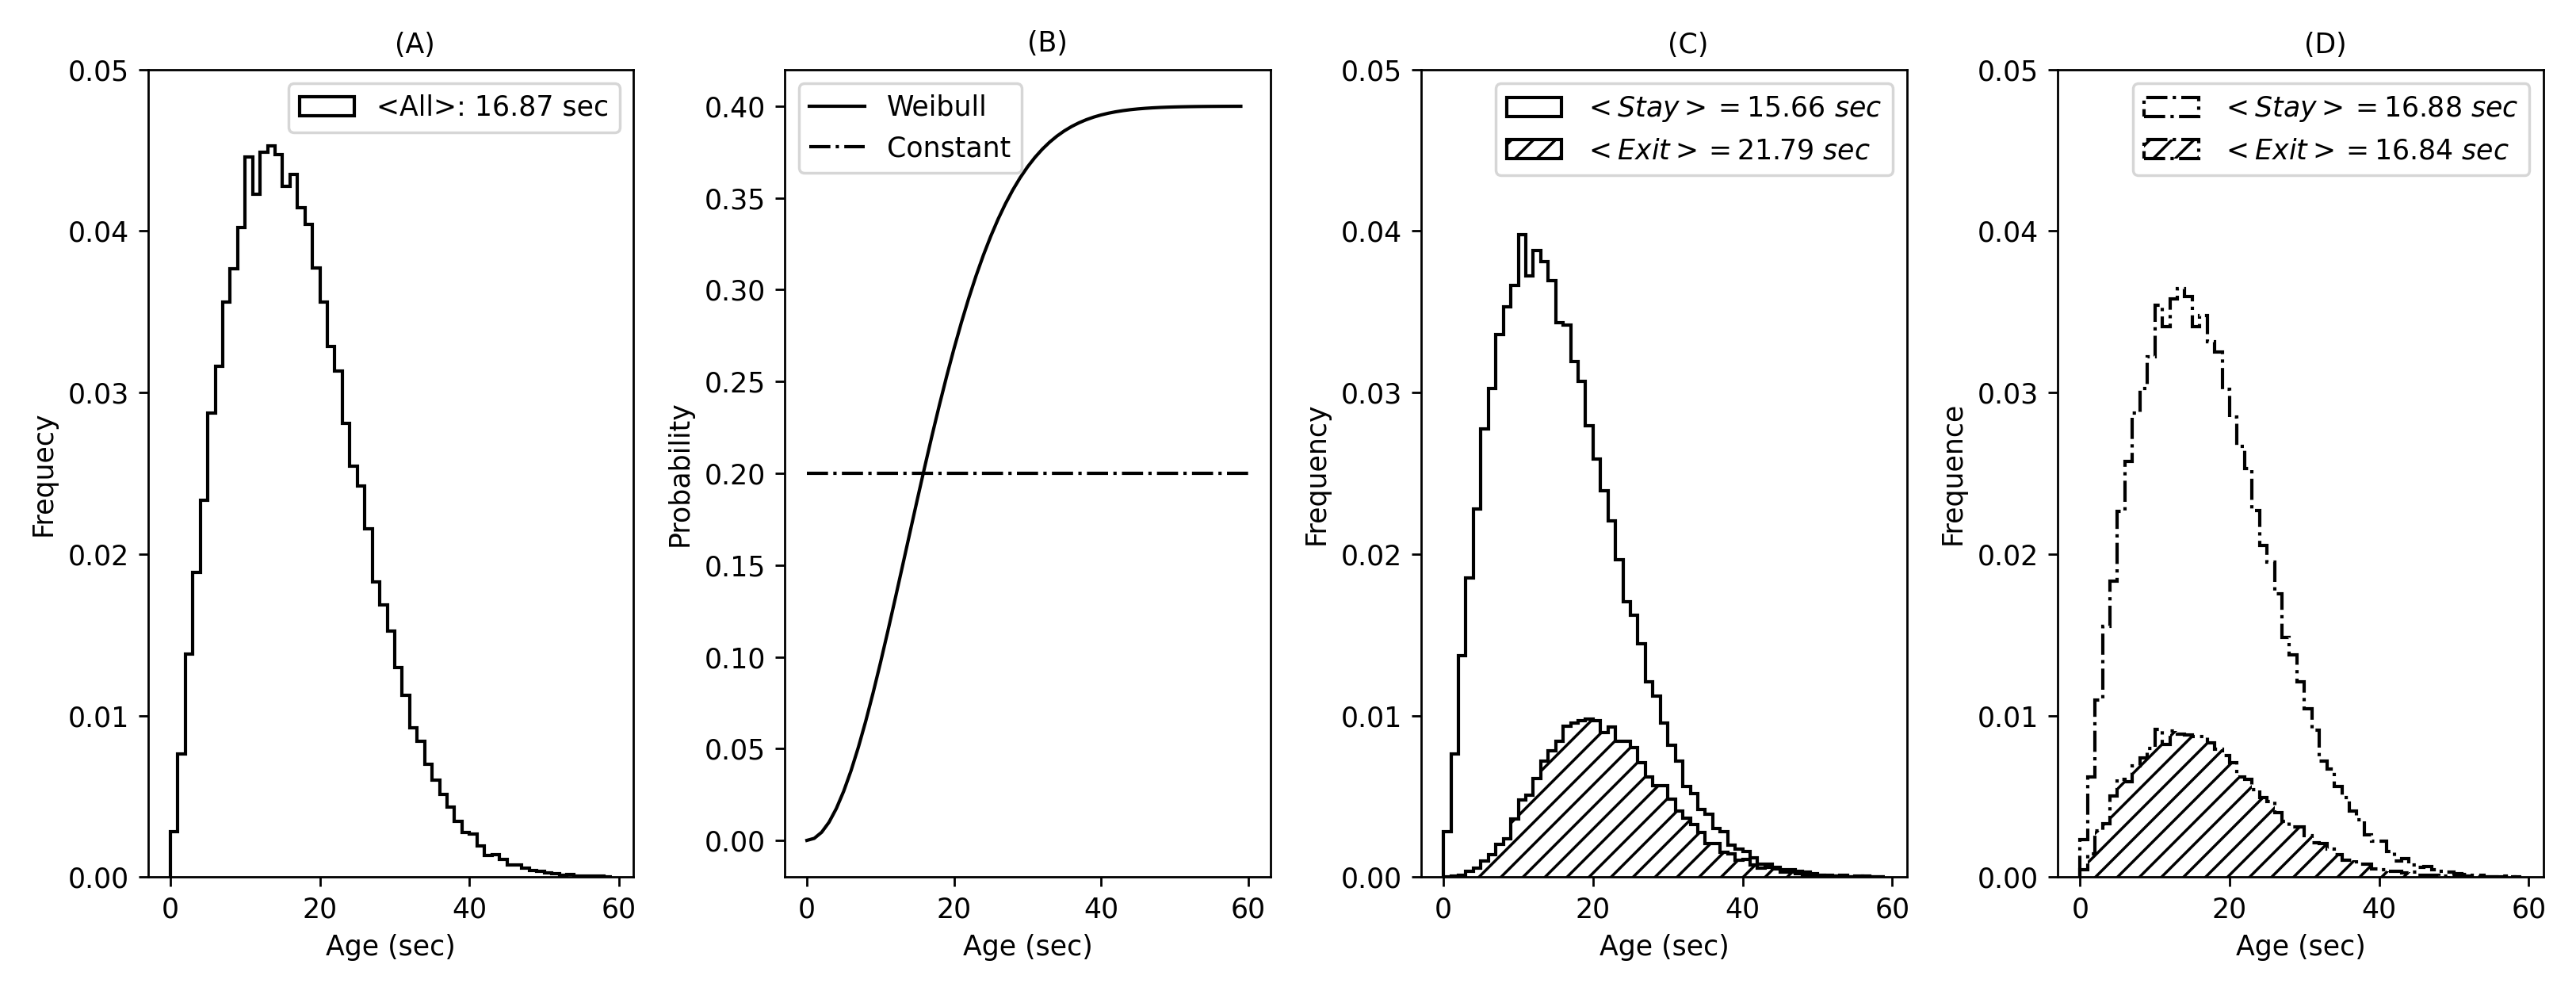

<ipython-input-21-14c7592d3e5a>:46: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  t = arange(0.0, 60, 1.0)


[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045] [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


Text(30, 0.051, '(D)')

In [21]:
### Cell for time-dependent Weibull & constnat transition probability.
from blooddvh import Weibull
n_particles = 100000

l    = 19.0
k    = 2.0
prob = 0.2 # exit probability of staying (->leaving) brain 0.2 , liver: 0.05
rtd  = Weibull(l, k, prob) #residence time distribution

# Particle aging following Weibull distribution
fig = plt.figure(figsize=(13,5)) 
fig.subplots_adjust(wspace=0.05)
img_grid = (1,4)

#    ax_diff.hist(diff, normed=True, range=(-10,10), bins=20, edgecolor='black', linewidth=0.9, alpha=0.8)
#    plt.xticks([-10,-5,0,5,10])

kwargs = dict(edgecolor='black', linewidth=0.9, alpha=0.8)

ax1 = plt.subplot2grid(img_grid, (0, 0)) #, colspan=2)
ax2 = plt.subplot2grid(img_grid, (0, 1)) #, colspan=2)
#ax3 = plt.subplot2grid(img_grid, (0, 3), colspan=1)
ax4 = plt.subplot2grid(img_grid, (0, 2)) #, colspan=2)
ax5 = plt.subplot2grid(img_grid, (0, 3)) #, colspan=2)

## Initial distribution
# weibull
s       = np.random.uniform(0,1, n_particles)
x       = rtd.cdf_inv(s) 

# status of blood particles after one-draw
# 0: staying, 1: leaving
status_c = np.zeros(n_particles)  # constant transition prob
status_w = np.zeros(n_particles)  # time-varying transition prob
p        = np.zeros(n_particles)  # 

kwargs_orig = dict(edgecolor='black',   linewidth=1.2, bins=range(0,60,1), histtype='step', linestyle='-', density=True)
ax1.hist(x, label='<All>: {:.2f} sec'.format(x.mean()), **kwargs_orig)
ax1.legend()
ax1.set_xlabel(r"Age (sec)")
ax1.set_ylabel("Frequecy")
ax1.set_ylim([0.0, 0.05])

## Time-dependent leaving probability 
#r"$\lambda$ = {:.2f}, $k$={:.2f}".format(l,k)
t = arange(0.0, 60, 1.0)
ax2.plot(t, rtd.cdf(t)*prob*2, "k-", linewidth=1.2,  label="Weibull")
ax2.plot([0.0, 60.0],[0.2, 0.2]    , "k-.", linewidth=1.2, label="Constant")
ax2.legend()
ax2.set_xlabel("Age (sec)")
ax2.set_ylabel("Probability")
#ax2.set_title(r"$f(t)=1-exp(-(t/\lambda)^k)$,s={:.2f}/0.5".format(prob))

### Leave or not
for i in range(n_particles):
    #p[i] = rtd.cdf(x[i]) #* prob/0.5
    p[i] = rtd.cdf(x[i]) * prob/0.5 #paper
    c0 = np.random.uniform()
    if p[i] > 1.0 :
        p[i] = 1.0
    #status_w[i] = np.random.choice([True, False], p = [p[i], 1.0-p[i]]) 
    status_w[i] = True if c0 < p[i] else False
    #status_c[i] = np.random.choice([True, False], p = [prob, 1.0-prob]) 
    status_c[i] = True if c0 < prob else False #np.random.choice([True, False], p = [prob, 1.0-prob]) 
        
### Histogram of outflow and staying-flow
kwargs_stay = dict(edgecolor='black', linewidth=1.2, bins=range(0,60,1), histtype='step')
kwargs_move = dict(edgecolor='black', linewidth=1.2, bins=range(0,60,1), histtype='step', hatch='///')

BP = np.column_stack((x, status_w))
BP_exit = BP[ BP[0:,1] == 1 ]
BP_stay = BP[ BP[0:,1] == 0 ]

weights_stay = np.ones_like(BP_stay[0:,0]) / n_particles
weights_exit = np.ones_like(BP_exit[0:,0]) / n_particles

ax4.hist(BP_stay[0:,0], weights=weights_stay, label=r"$<Stay>=%.2f\ sec$" % (BP_stay[0:,0].mean()), **kwargs_stay, linestyle='-')
ax4.hist(BP_exit[0:,0], weights=weights_exit, label=r"$<Exit>=%.2f\ sec$" % (BP_exit[0:,0].mean()), **kwargs_move, linestyle='-')
y_ticks = ax4.get_yticks()
print(y_ticks, ax4.get_yticklabels())
ax4.set_xlabel("Age (sec)")
ax4.set_ylabel("Frequency")
ax4.set_ylim([0.0, 0.05])
ax4.legend()

### Histogram of outflow and staying-flow
BP = np.column_stack((x, status_c))
BP_exit = BP[ BP[0:,1] == 1 ]
BP_stay = BP[ BP[0:,1] == 0 ]

weights_stay = np.ones_like(BP_stay[0:,0]) / n_particles
weights_exit = np.ones_like(BP_exit[0:,0]) / n_particles

ax5.hist(BP_stay[0:,0], weights=weights_stay, label=r"$<Stay>=%.2f\ sec$" % (BP_stay[0:,0].mean()), **kwargs_stay,linestyle='-.')
ax5.hist(BP_exit[0:,0], weights=weights_exit, label=r"$<Exit>=%.2f\ sec$" % (BP_exit[0:,0].mean()), **kwargs_move,linestyle='-.')
ax5.set_xlabel("Age (sec)")
ax5.set_ylabel("Frequence")
ax5.set_ylim([0.0, 0.05])
ax5.legend()


ax1.text(30, 0.051,"(A)", color='k', fontsize=10)
ax2.text(30, 0.43 ,"(B)", color='k', fontsize=10)
ax4.text(30, 0.051,"(C)", color='k', fontsize=10)
ax5.text(30, 0.051,"(D)", color='k', fontsize=10)

#plt.savefig(top_dir+"results/time_dep_exit_prob.png", dpi=300)
#ax4.hist(p, bins=arange(0.0,1.0,0.1), label=r'${:.2f}$'.format(p.mean()))
#ax4.legend()

<IPython.core.display.Javascript object>


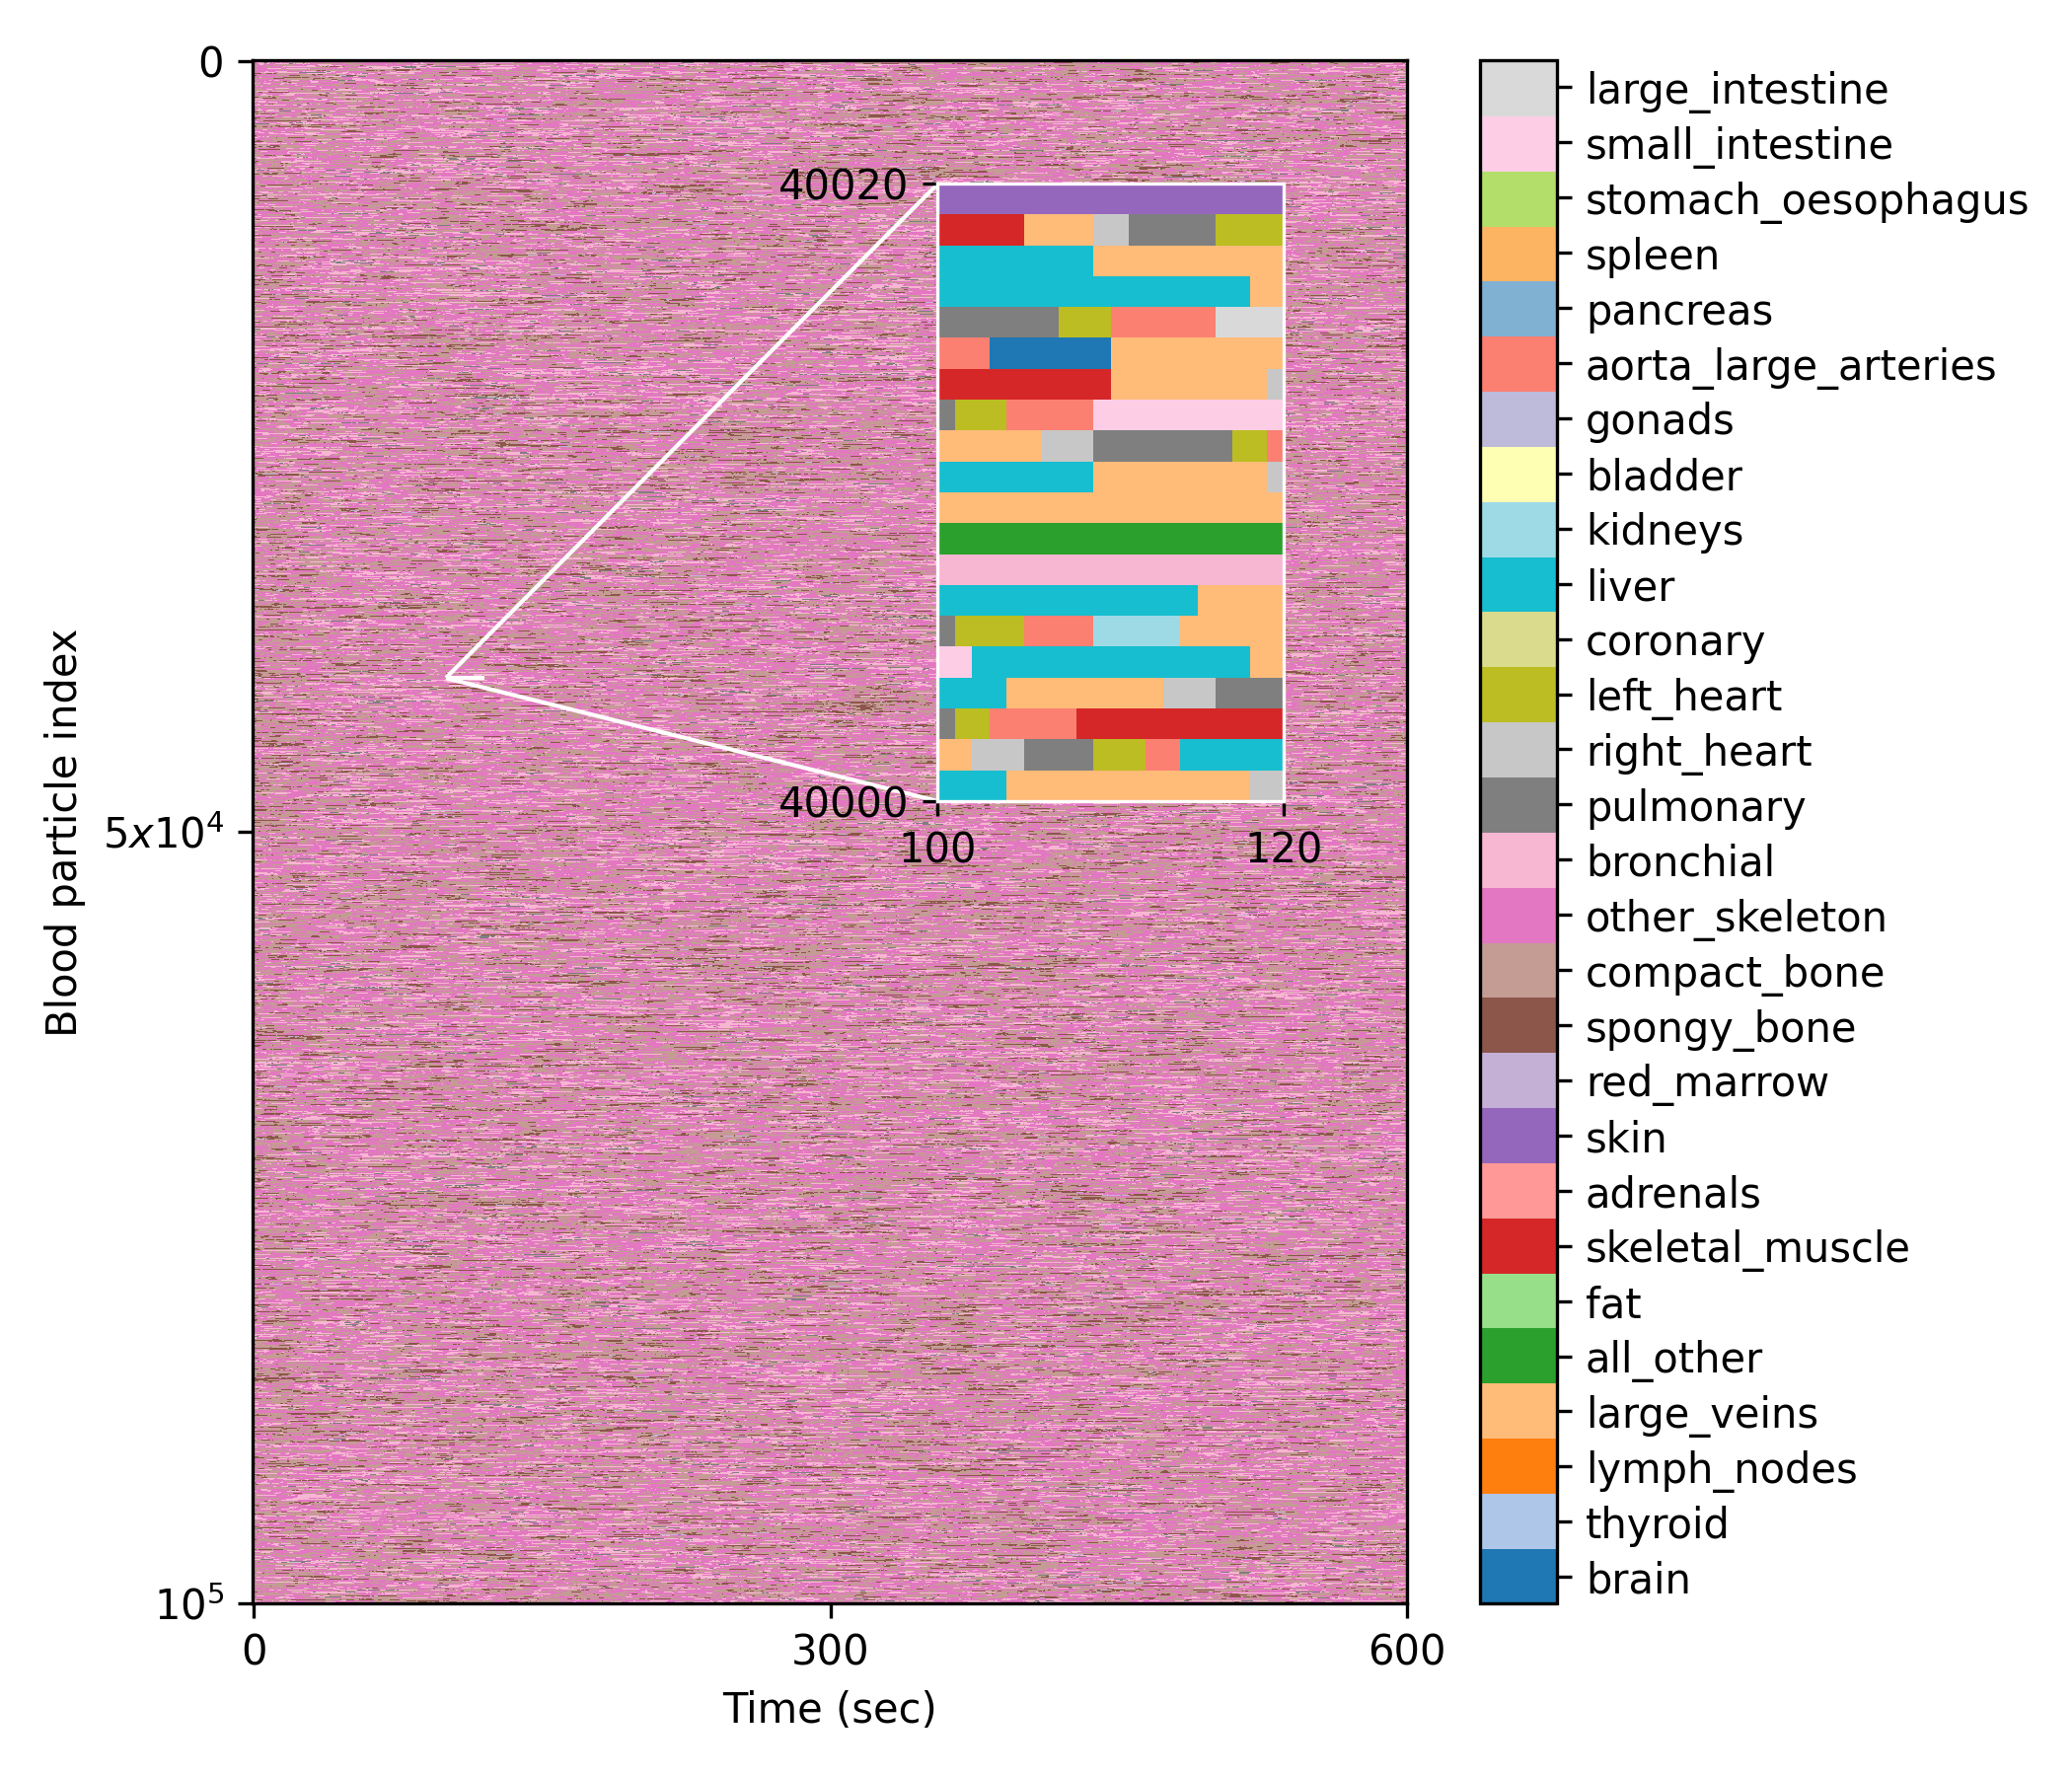

[Text(0, 40020, '40020'), Text(0, 40000, '40000')]

In [17]:
### Drawing Blood particle path

# ------ Draw grid images
fig, ax = plt.subplots(figsize=(7,6)) 
fig.subplots_adjust(left=0.2, bottom=0.2)
im   = ax.imshow(BP_w2.df.values, aspect='auto', cmap=comp_cmap)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Blood particle index")
ax.set_xticks([0,300,600])
ax.set_xticklabels(["0","300","600"])
ax.set_yticks([0,50000,100000])
ax.set_yticklabels(["0",r"$5x10^4$",r"$10^5$"])

ncolors = 28
mappable = cm.ScalarMappable(cmap=comp_cmap)
mappable.set_array([])
mappable.set_clim(-0.5, ncolors+0.5)
clb = plt.colorbar(mappable)
clb.set_ticks(np.linspace(0, ncolors, ncolors))
clb.set_ticklabels(model.name)
axins = inset_axes(ax, width="30%", height="40%", loc=1, borderpad=3)
mark_inset(ax, axins, loc1=2, loc2=3, fc="1", ec="1")

y0 = 40000
y1 = y0 + 20
x0 = 100
x1 = x0 + 20
axins.imshow(BP_w2.df.values[y0:y1, x0:x1], aspect='auto', cmap=comp_cmap, extent=[x0,x1,y0,y1])
axins.spines['top'].set_color('white')
axins.spines['bottom'].set_color('white')
axins.spines['right'].set_color('white')
axins.spines['left'].set_color('white')
axins.set_xticks([100,120])
axins.set_xticklabels(["100","120"])
axins.set_yticks([40020, 40000])
axins.set_yticklabels(["40020","40000"])
##axins.tick_params(axis='x', colors='1')
##axins.tick_params(axis='y', colors='1')
##axins.yaxis.label.set_color('1')
##axins.xaxis.label.set_color('1')

#fig.savefig(top_dir+"results/blood_path_100K_10min_0.png", dpi=300)


<IPython.core.display.Javascript object>


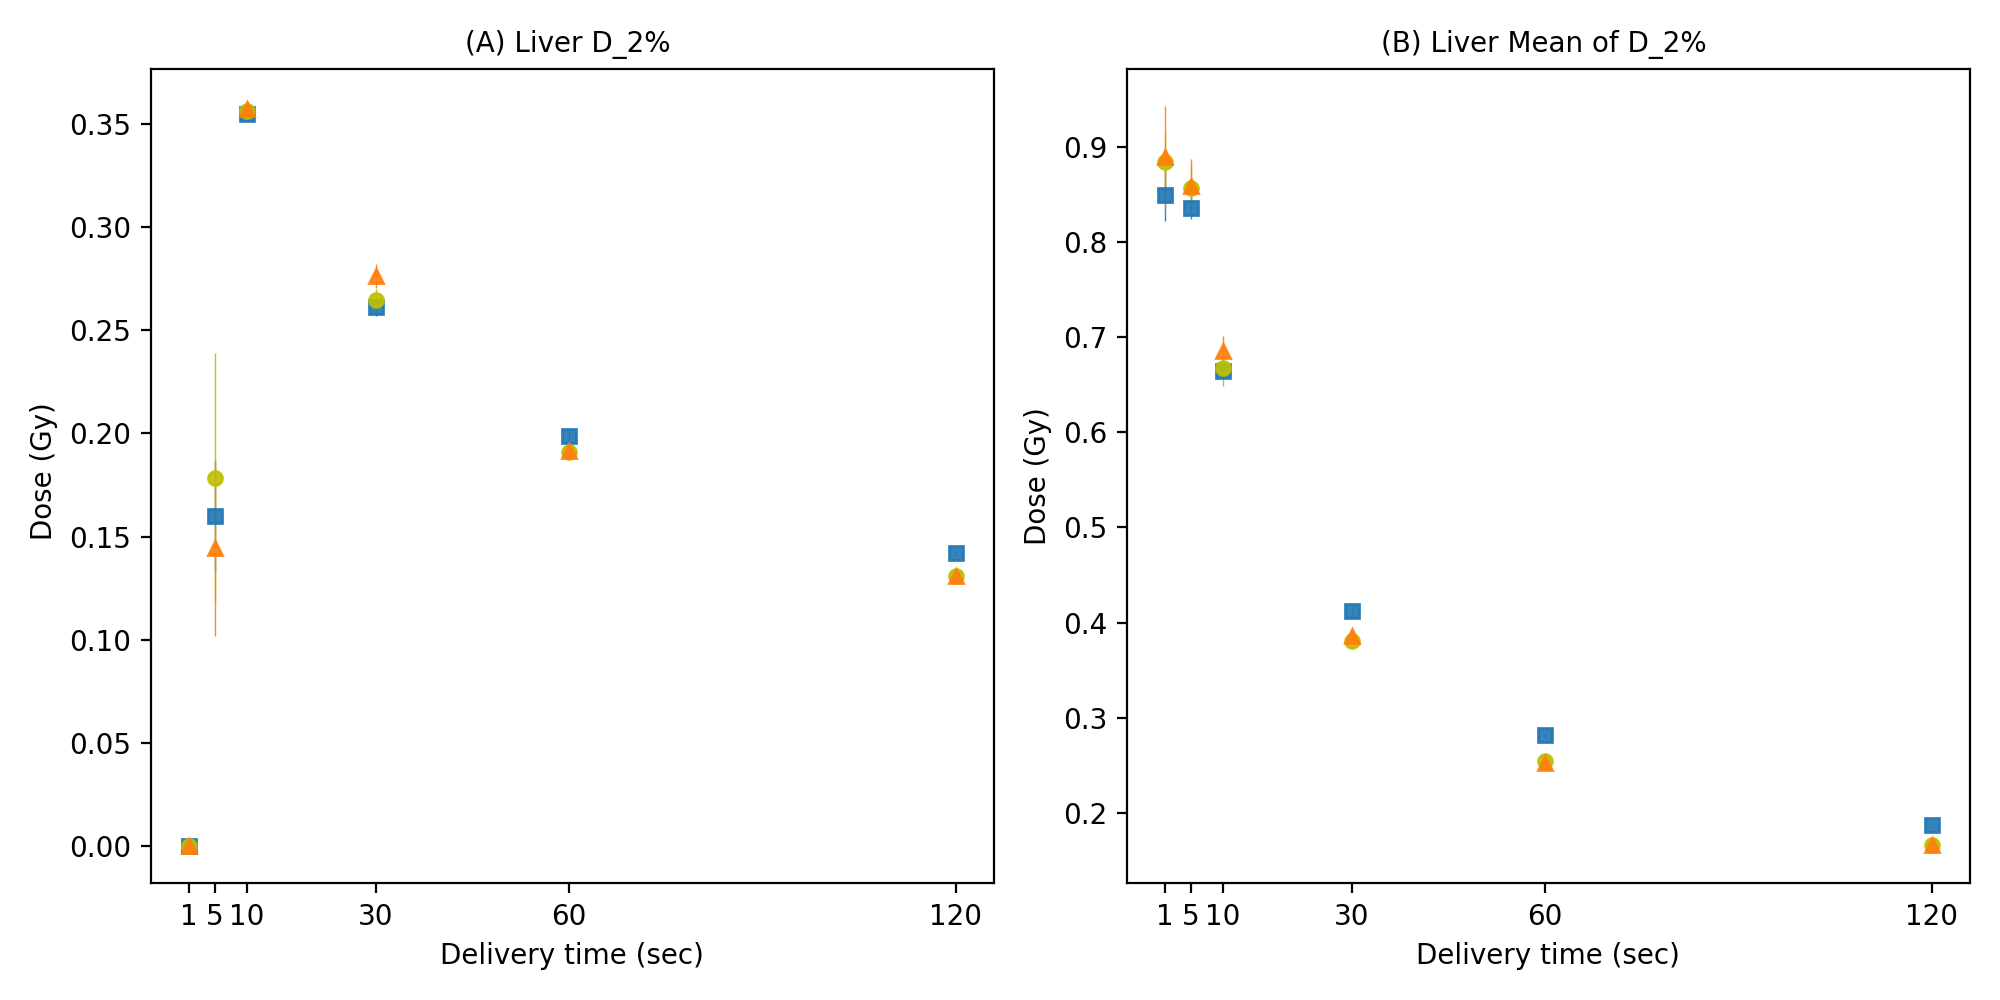

In [26]:
# Particle aging following Weibull distribution
# Brain results
#title = "Brain"
#B = {'M' : pd.read_csv(top_dir + "brain_M_dec10.csv"), 
#     'W1': pd.read_csv(top_dir + "brain_W1_dec10.csv"),
#     'W2': pd.read_csv(top_dir + "brain_W2_dec10.csv")}

# Liver results
title = "Liver"
B = {'M' : pd.read_csv(top_dir + "liver_M_dec10.csv"), 
     'W1': pd.read_csv(top_dir + "liver_W1_dec10.csv"),
     'W2': pd.read_csv(top_dir + "liver_W2_dec10.csv")}


fig = plt.figure(figsize=(10,5)) 
fig.tight_layout()
img_grid = (1,2)

kwargs    = dict(edgecolor='black', linewidth=0.9, alpha=0.8)
kwargs_M  = dict(alpha=0.9, markersize=5, fmt='s', capthick=12, linewidth=0.5)
kwargs_W1 = dict(alpha=0.9, markersize=5, fmt='yo',capthick=12, linewidth=0.5)
kwargs_W2 = dict(alpha=0.9, markersize=5, fmt='^', capthick=12, linewidth=0.5)

ax1 = plt.subplot2grid(img_grid, (0, 0)) 
ax2 = plt.subplot2grid(img_grid, (0, 1)) #, sharex=ax1, sharey=ax1 
#ax3 = plt.subplot2grid(img_grid, (0, 2))
#ax4 = plt.subplot2grid(img_grid, (1, 0)) 
#ax5 = plt.subplot2grid(img_grid, (1, 1)) 
#ax6 = plt.subplot2grid(img_grid, (1, 2)) 


def draw_value(ax, metric, ylabel, title):
    ax.errorbar( delivery_time , B['M'][metric].values,  yerr=B['M'][metric+"_std"].values, label="Constant", **kwargs_M)
    ax.errorbar( delivery_time , B['W1'][metric].values, yerr=B['W1'][metric+"_std"].values, label=r"Weibull, $\kappa=1$", **kwargs_W1)
    ax.errorbar( delivery_time , B['W2'][metric].values, yerr=B['W2'][metric+"_std"].values, label=r"Weibull, $\kappa=2$", **kwargs_W2)
    #ax.legend(loc='upper left')
    ax.set_xlabel("Delivery time (sec)")
    ax.set_xticks(delivery_time)
    ax.set_xticklabels(delivery_time)
    ax.set_ylabel(ylabel)
    ax.set_title(title,color='k', fontsize=10)

# V 
#draw_value(ax1, 'v', " Volume (a.u)", "(A) " + title + " Blood particles of Dose > 0 Gy" )
#draw_value(ax2, 'md', "Dose (Gy)", "(B) " + title + " Mean dose of Dose > 0 Gy")
#fig.savefig(top_dir+"results/dose_rate_dep_v_md_" + title + ".png", dpi=300)

# vt_low
#draw_value(ax1, 'vt_low', " Volume (a.u)", "(A) " + title + " Blood particles of Dose > 0.05 Gy" )
#draw_value(ax2, 'md_low', "Dose (Gy)", "(B) " + title + " Mean dose of Dose > 0.05 Gy")
#fig.savefig(top_dir+"results/dose_rate_dep_vt_md_low_" + title + ".png", dpi=300)

# vt_high
#draw_value(ax1, 'vt_high', " Volume (a.u)", "(A) " + title + " Blood particles of Dose > 0.5 Gy" )
#draw_value(ax2, 'mdt2', "Dose (Gy)", "(B) " + title + " Mean dose of Dose > 0.5 Gy")
#fig.savefig(top_dir+"results/dose_rate_dep_vt_md_high_" + title + ".png", dpi=300)

# t2
draw_value(ax1, 't2', " Dose (Gy)", "(A) " + title + " D_2% " )
draw_value(ax2, 'md_t2', "Dose (Gy)", "(B) " + title + " Mean of D_2% ")
#fig.savefig(top_dir+"results/dose_rate_dep_top2_" + title + ".png", dpi=300)

# t3
#draw_value(ax1, 't3', " Dose(Gy)", "(A) " + title + " D_3% " )
#draw_value(ax2, 'md_t3', "Dose (Gy)", "(B) " + title + " Mean of D_3% ")
#fig.savefig(top_dir+"results/dose_rate_dep_top3_" + title + ".png", dpi=300)

#draw_value(ax2, 'vt', "Volume (a.u)", "(B) Blood particles of Dose > " + str(threshold_low) + " Gy")
#draw_value(ax4, 'md', "Dose (Gy)", "(D) Mean dose of Dose > 0 Gy")
#draw_value(ax5, 'mdt', "Dose (Gy)" , "(E) Mean dose of Dose > " + str(threshold) + " Gy")
#draw_value(ax3, 'd_max', "Dose (Gy)", "(C) Max dose of blood particles")
#draw_value(ax6, 'd_min', "Dose (Gy)", "(F) Min dose of blood particles")




<IPython.core.display.Javascript object>


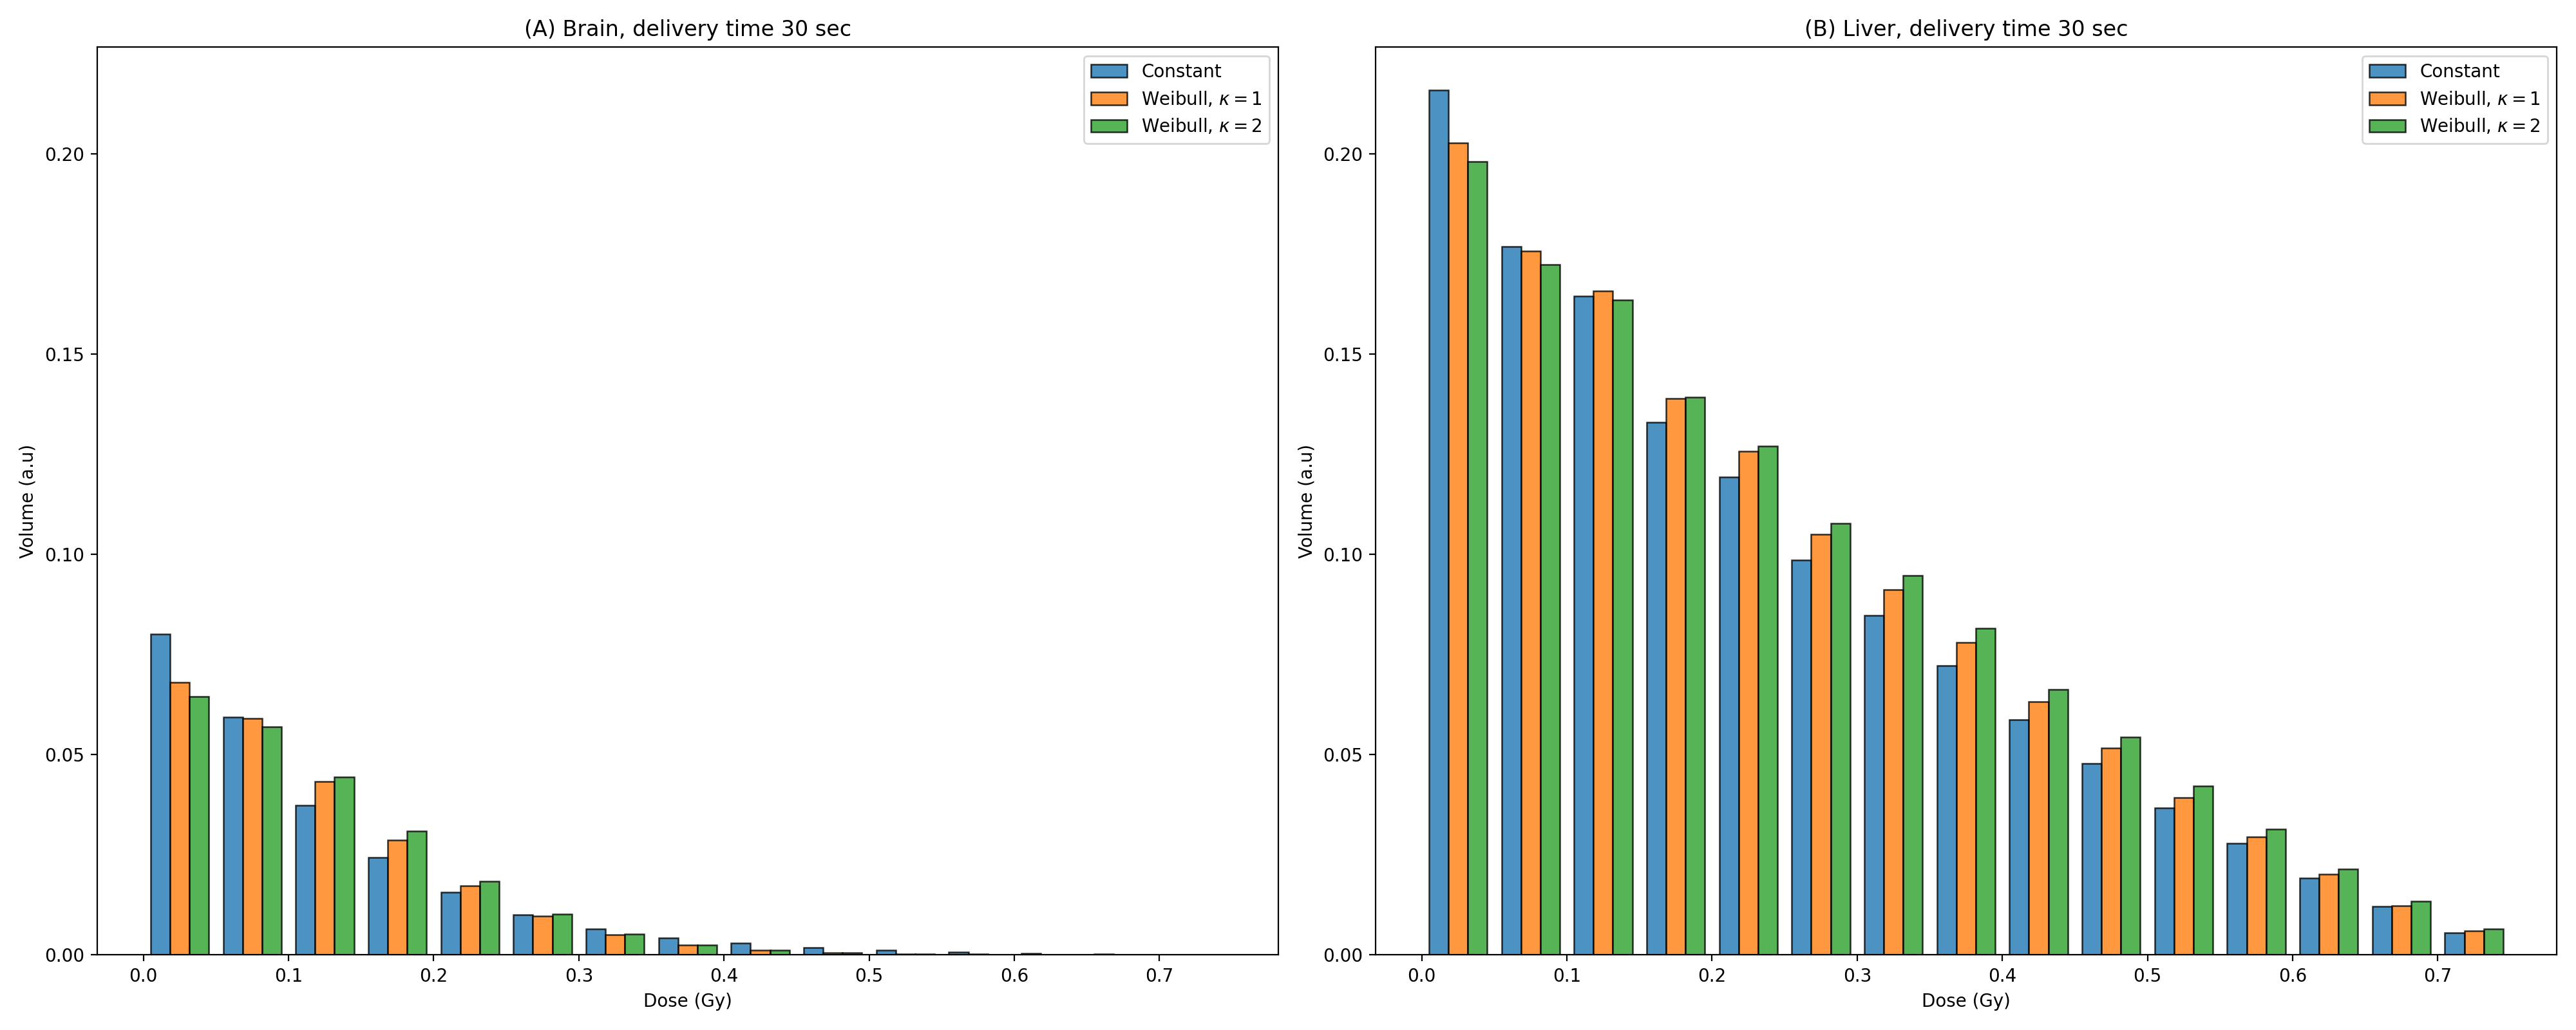

Text(0.5, 1.0, '(B) Liver, delivery time 30 sec')

In [34]:
total_nb_particles = 100_000

# histograms side by side for Brain & Liver
fig = plt.figure(figsize=(10,4)) 
fig.subplots_adjust(wspace=0.05)
img_grid = (1,2)

# Brain
ax1 = plt.subplot2grid(img_grid, (0, 0))


my_bins = np.arange(0.0, 0.8, 0.05)

kwargs_orig = dict(edgecolor='black', alpha=0.8,  linewidth=0.9, bins=my_bins, cumulative=-1, 
                   #histtype = 'step',
                   #linestyle = ["solid","dashed","dotted"],
                   label=["Constant", r"Weibull, $\kappa=1$",r"Weibull, $\kappa=2$"])

brain_weights = [np.ones_like(BD_brain['m'])/total_nb_particles,
                 np.ones_like(BD_brain['w1'])/total_nb_particles,
                 np.ones_like(BD_brain['w2'])/total_nb_particles]

ax1.hist([BD_brain['m'], BD_brain['w1'], BD_brain['w2']], weights=brain_weights, **kwargs_orig)
ax1.legend()
ax1.set_xlabel("Dose (Gy)")
ax1.set_ylabel("Volume (a.u)")
ax1.set_title("(A) Brain, delivery time 30 sec")


# Liver
liver_weights = [np.ones_like(BD_liver['m'])/total_nb_particles,
                 np.ones_like(BD_liver['w1'])/total_nb_particles,
                 np.ones_like(BD_liver['w2'])/total_nb_particles]


ax2 = plt.subplot2grid(img_grid, (0, 1), sharex=ax1, sharey=ax1)
ax2.hist([BD_liver['m'], BD_liver['w1'], BD_liver['w2']], weights=liver_weights, **kwargs_orig)
ax2.legend()
ax2.set_xlabel("Dose (Gy)")
ax2.set_ylabel("Volume (a.u)")
ax2.set_title("(B) Liver, delivery time 30 sec")

#fig.savefig(top_dir+"results/blood_dvh_30sec_delivery_time.png", dpi=300)



In [13]:

# Produce results (mean, non-zero bp volume, bp volume above threshold)
# for x points are dose-rate (1 sec, 5 sec, 10 sec, 30 sec, 60 sec, 120) 
# for y error bar beam starting point from 5 points 0 min, 2 min, 4 min, 6 min, 8 min. 
#print(BD[f].size*0.03)
#print(top3.size, top3.mean())

## Input parameters
delivery_time  = np.array([1, 5, 10, 30, 60, 120])
delivery_start = np.array([0, 120, 240, 360, 479])


# Results array
# 3 for M, W1, W2
vol_nonzero     = np.zeros([len(delivery_time), 3]) 
vol_nonzero_std = np.zeros([len(delivery_time), 3]) 

# Vol above 0.05
vol_threshold1     = np.zeros([len(delivery_time), 3]) 
vol_threshold1_std = np.zeros([len(delivery_time), 3]) 
threshold_low     = 0.05 #Gy

# Vol above 0.5
vol_threshold2     = np.zeros([len(delivery_time), 3]) 
vol_threshold2_std = np.zeros([len(delivery_time), 3]) 
threshold_high     = 0.5 #Gy

# Mean dose for all
mean_dose       = np.zeros([len(delivery_time), 3]) #For non-zero blood
mean_dose_std   = np.zeros([len(delivery_time), 3]) 

# Mean dose for BP > 0.05 (threshold_0p05)
mean_dose_threshold1       = np.zeros([len(delivery_time), 3]) #For non-zero blood
mean_dose_threshold1_std   = np.zeros([len(delivery_time), 3]) 

# Mean dose for BP > 0.5 (threshold_0p5)
mean_dose_threshold2       = np.zeros([len(delivery_time), 3]) #For non-zero blood
mean_dose_threshold2_std   = np.zeros([len(delivery_time), 3]) 

# Top 2% of all
threshold_t2 = 0.02 
t2dose       = np.zeros([len(delivery_time), 3])
t2dose_std   = np.zeros([len(delivery_time), 3]) 

# Mea of top 2% dose
mean_t2dose       = np.zeros([len(delivery_time), 3])
mean_t2dose_std   = np.zeros([len(delivery_time), 3]) 

# Top 3% of all
threshold_t3 = 0.03
t3dose       = np.zeros([len(delivery_time), 3])
t3dose_std   = np.zeros([len(delivery_time), 3]) 

# Mean of top 3% 
mean_t3dose       = np.zeros([len(delivery_time), 3])
mean_t3dose_std   = np.zeros([len(delivery_time), 3]) 

# Max dose
max_dose       = np.zeros([len(delivery_time), 3])
max_dose_std   = np.zeros([len(delivery_time), 3]) 

# Min dose 
min_dose       = np.zeros([len(delivery_time), 3])
min_dose_std   = np.zeros([len(delivery_time), 3]) 

organ_id = 19 #For brain 0, For Liver 19
tps_dvh  = LiverDVH[0] #or LiverDVH[0] or BrainDVH[0]

### For X position
for j, dT in enumerate(delivery_time):
    print(dT)
    
    v_nonzero     = np.zeros([len(delivery_start),3])
    v_threshold1  = np.zeros([len(delivery_start),3])
    v_threshold2  = np.zeros([len(delivery_start),3])
    md_nonzero    = np.zeros([len(delivery_start),3])
    md_threshold1 = np.zeros([len(delivery_start),3])
    md_threshold2 = np.zeros([len(delivery_start),3])
    md_t2         = np.zeros([len(delivery_start),3])
    md_t3         = np.zeros([len(delivery_start),3])
    t2            = np.zeros([len(delivery_start),3])
    t3            = np.zeros([len(delivery_start),3])
    d_max         = np.zeros([len(delivery_start),3])
    d_min         = np.zeros([len(delivery_start),3])
    
    
    for i, T0 in enumerate(delivery_start):
        print(dT, T0)
        
        # 1. Build DVH
        dvh4d = tDVH()
        dvh4d.add_array(dT, tps_dvh) 

        # 2. compute blood dose
        # Blood dose to Markov
        BD_m = bDVH(BP_m.df, BP_m.dt)
        BD_m.add_dose(dvh4d, organ_id, T0 )
        # Blood dose to Weibull (K=1)
        BD_w1 = bDVH(BP_w1.df, BP_w1.dt)
        BD_w1.add_dose(dvh4d, organ_id, T0 )
        # Blood dose to Weibull (K=2)
        BD_w2 = bDVH(BP_w2.df, BP_w2.dt)
        BD_w2.add_dose(dvh4d, organ_id, T0 )

        BD = {'m'      : BD_m.dose [BD_m.dose  > 0.0], 
              'w1'     : BD_w1.dose[BD_w1.dose > 0.0], 
              'w2'     : BD_w2.dose[BD_w2.dose > 0.0],
              'm_cut1' : BD_m.dose [BD_m.dose  > threshold_low], 
              'w1_cut1': BD_w1.dose[BD_w1.dose > threshold_low], 
              'w2_cut1': BD_w2.dose[BD_w2.dose > threshold_low],
              'm_cut2' : BD_m.dose [BD_m.dose  > threshold_high], 
              'w1_cut2': BD_w1.dose[BD_w1.dose > threshold_high], 
              'w2_cut2': BD_w2.dose[BD_w2.dose > threshold_high]}
        
        v_nonzero[i]    = [ BD['m'].size/total_nb_particles, BD['w1'].size/total_nb_particles, BD['w2'].size/total_nb_particles]
        
        v_threshold1[i]  = [ BD['m_cut1'].size/total_nb_particles, BD['w1_cut1'].size/total_nb_particles, BD['w2_cut1'].size/total_nb_particles] 
        v_threshold2[i]  = [ BD['m_cut2'].size/total_nb_particles, BD['w1_cut2'].size/total_nb_particles, BD['w2_cut2'].size/total_nb_particles] 

        md_nonzero[i]    = [ BD['m'].mean(), BD['w1'].mean(), BD['w2'].mean() ]
        md_threshold1[i] = [ BD['m_cut1'].mean(), BD['w1_cut1'].mean(), BD['w2_cut1'].mean() ]
        md_threshold2[i] = [ BD['m_cut2'].mean(), BD['w1_cut2'].mean(), BD['w2_cut2'].mean() ]
        
        np_t2    = int(total_nb_particles*threshold_t2)
        np_t3    = int(total_nb_particles*threshold_t3)
        s_m      = np.sort(BD_m.dose)
        s_w1     = np.sort(BD_w1.dose)
        s_w2     = np.sort(BD_w2.dose)
        
        md_t2[i] = [ s_m[-np_t2:].mean(), s_w1[-np_t2:].mean(), s_w2[-np_t2:].mean() ]
        md_t3[i] = [ s_m[-np_t3:].mean(), s_w1[-np_t3:].mean(), s_w2[-np_t3:].mean() ]

        t2[i] = [ s_m[-np_t2], s_w1[-np_t2], s_w2[-np_t2] ]
        t3[i] = [ s_m[-np_t3], s_w1[-np_t3], s_w2[-np_t3] ]
        
        d_max[i] = [ BD['m'].max(), BD['w1'].max(), BD['w2'].max() ]
        d_min[i] = [ BD['m'].min(), BD['w1'].min(), BD['w2'].min() ]
        

    print("volume D > 0")
    print(v_nonzero)
    vol_nonzero[j]       = v_nonzero.mean(axis=0)
    vol_nonzero_std[j]   = v_nonzero.std(axis=0)
    print(vol_nonzero[j], vol_nonzero_std[j])
    
    print("volume D > 0.05 Gy")
    print(v_threshold1)
    vol_threshold1[j]     = v_threshold1.mean(axis=0)
    vol_threshold1_std[j] = v_threshold1.std(axis=0)
    print(vol_threshold1[j], vol_threshold1_std[j])

    print("volume D > 0.5 Gy")
    print(v_threshold2)
    vol_threshold2[j]     = v_threshold2.mean(axis=0)
    vol_threshold2_std[j] = v_threshold2.std(axis=0)
    print(vol_threshold2[j], vol_threshold2_std[j])
    
    print("Mean D > 0 Gy")
    print(md_nonzero)
    mean_dose[j]     = md_nonzero.mean(axis=0)
    mean_dose_std[j] = md_nonzero.std(axis=0)
    print(mean_dose[j], mean_dose_std[j])
    
    print("Mean D > 0.05 Gy")
    print(md_threshold1)
    mean_dose_threshold1[j]     = md_threshold1.mean(axis=0)
    mean_dose_threshold1_std[j] = md_threshold1.std(axis=0)
    print(mean_dose_threshold1[j], mean_dose_threshold1_std[j])

    print("Mean D > 0.5 Gy")
    print(md_threshold2)
    mean_dose_threshold2[j]     = md_threshold2.mean(axis=0)
    mean_dose_threshold2_std[j] = md_threshold2.std(axis=0)
    print(mean_dose_threshold2[j], mean_dose_threshold2_std[j])
    
    print("Top 2% dose")
    print(t2)
    t2dose[j]     = t2.mean(axis=0)
    t2dose_std[j] = t2.std(axis=0)
    print(t2dose[j], t2dose_std[j])

    print("Top 2% mean dose")
    print(md_t2)
    mean_t2dose[j]     = md_t2.mean(axis=0)
    mean_t2dose_std[j] = md_t2.std(axis=0)
    print(mean_t2dose[j], mean_t2dose_std[j])

    print("Top 3% dose")
    print(t3)
    t3dose[j]     = t3.mean(axis=0)
    t3dose_std[j] = t3.std(axis=0)
    print(t3dose[j], t3dose_std[j])

    print("Top 3% mean dose")
    print(md_t3)
    mean_t3dose[j]     = md_t3.mean(axis=0)
    mean_t3dose_std[j] = md_t3.std(axis=0)
    print(mean_t3dose[j], mean_t3dose_std[j])

    print("Max D > 0 Gy") 
    print(d_max)
    max_dose[j]     = d_max.mean(axis=0)
    max_dose_std[j] = d_max.std(axis=0)
    print(max_dose[j], max_dose_std[j])

    print("Min D > 0 Gy") 
    print(d_min)
    min_dose[j]     = d_min.mean(axis=0)
    min_dose_std[j] = d_min.std(axis=0)
    print(min_dose[j], min_dose_std[j])

1
1 0
1 120
1 240
1 360
1 479
volume D > 0
[[0.01975 0.0194  0.02004]
 [0.02055 0.02093 0.02071]
 [0.01998 0.02064 0.02011]
 [0.02001 0.02071 0.02039]
 [0.0203  0.02067 0.02147]]
[0.020118 0.02047  0.020544] [0.00027781 0.00054461 0.00051983]
volume D > 0.05 Gy
[[0.00692 0.00703 0.00713]
 [0.00719 0.00756 0.00788]
 [0.00719 0.00746 0.00717]
 [0.00684 0.00753 0.00736]
 [0.0075  0.00736 0.00831]]
[0.007128 0.007388 0.00757 ] [0.00023336 0.00019177 0.00045638]
volume D > 0.5 Gy
[[0.00586 0.00585 0.00604]
 [0.00601 0.00646 0.00664]
 [0.00601 0.00637 0.00602]
 [0.00588 0.00632 0.0061 ]
 [0.0062  0.0062  0.00692]]
[0.005992 0.00624  0.006344] [0.00012156 0.00021232 0.00036778]
Mean D > 0 Gy
[[0.85094921 0.86322531 0.82588451]
 [0.84505553 0.88465142 0.89494465]
 [0.83023741 0.87106681 0.85241232]
 [0.81629413 0.86781472 0.84326478]
 [0.87965928 0.83357255 0.90932481]]
[0.84443911 0.86406616 0.86516621] [0.02134034 0.01683675 0.03169266]
Mean D > 0.05 Gy
[[2.42007134 2.37431587 2.31342453]
 [

30 120
30 240
30 360
30 479
volume D > 0
[[0.12807 0.10822 0.10477]
 [0.12659 0.11396 0.10564]
 [0.12586 0.11352 0.10513]
 [0.1267  0.11461 0.10676]
 [0.12793 0.11222 0.10534]]
[0.12703  0.112506 0.105528] [0.00084416 0.00228126 0.00067804]
volume D > 0.05 Gy
[[0.08044 0.07862 0.07918]
 [0.07914 0.0833  0.0811 ]
 [0.07846 0.08304 0.08045]
 [0.07981 0.08366 0.08214]
 [0.07944 0.08252 0.08093]]
[0.079458 0.082228 0.08076 ] [0.00066116 0.00184185 0.00096347]
volume D > 0.5 Gy
[[0.0037  0.00205 0.00208]
 [0.004   0.00239 0.00232]
 [0.00391 0.00247 0.00231]
 [0.00423 0.00245 0.0023 ]
 [0.00381 0.00245 0.00227]]
[0.00393  0.002362 0.002256] [1.80333025e-04 1.58290871e-04 8.95767827e-05]
Mean D > 0 Gy
[[0.13222726 0.15107762 0.16154775]
 [0.13340669 0.15425427 0.16557541]
 [0.13483465 0.15270218 0.16700221]
 [0.13606373 0.15386417 0.16730351]
 [0.13369197 0.15344737 0.16702195]]
[0.13404486 0.15306912 0.16569017] [0.00130653 0.00112076 0.00215735]
Mean D > 0.05 Gy
[[0.2071851  0.20501036 0.21

<ipython-input-13-bec8b29af45d>:121: RuntimeWarning: Mean of empty slice.
  md_threshold2[i] = [ BD['m_cut2'].mean(), BD['w1_cut2'].mean(), BD['w2_cut2'].mean() ]


120 120
120 240
120 360
120 479
volume D > 0
[[0.37624 0.32952 0.31229]
 [0.37349 0.33646 0.31083]
 [0.37227 0.33869 0.31058]
 [0.37539 0.33844 0.31039]
 [0.37262 0.33395 0.31016]]
[0.374002 0.335412 0.31085 ] [0.00155609 0.00340193 0.00075294]
volume D > 0.05 Gy
[[0.13447 0.14604 0.15462]
 [0.13207 0.15092 0.154  ]
 [0.13196 0.15122 0.15333]
 [0.13454 0.1511  0.15428]
 [0.13195 0.14814 0.15389]]
[0.132998 0.149484 0.154024] [0.00123138 0.00206663 0.00042917]
volume D > 0.5 Gy
[[1.e-05 0.e+00 0.e+00]
 [2.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]]
[6.e-06 0.e+00 0.e+00] [8.e-06 0.e+00 0.e+00]
Mean D > 0 Gy
[[0.04582973 0.05174612 0.05620153]
 [0.04547132 0.05256506 0.05623909]
 [0.04550951 0.05225625 0.0562561 ]
 [0.04573904 0.05230955 0.05678561]
 [0.04537808 0.05186359 0.05624252]]
[0.04558554 0.05214812 0.05634497] [0.00017033 0.00030138 0.00022106]
Mean D > 0.05 Gy
[[0.09787572 0.0900967  0.09025947]
 [0.09781806 0.09099365 0.0902701